## Notes
eMERGE PGx uses the GRCh37 build. It only includes SNPs.

## Data structures & variables

### snp
Represents a variant. 'AA', 'EA' and 'global' are the allele frequencies in African America, European American and global populations, respectively. rsid is the dbsnp identifier, if it exists. Type is the type of the variant.

    {'AA': {'A': 0.000740192, 'G': 0.99926},
     'EA': {'A': 0.0, 'G': 1.0},
     'global': {'A': 0.000166389, 'G': 0.999834},
     'rsid': '',
     'type': 'Upstream'}


### gene
Represents a gene as a dict where the values are snps. The keys for the variants are their chromosome and base position (see `pos` below).

    {'Chr10:96696455':
         {'AA': {'A': 0.000740192, 'G': 0.99926},
          'EA': {'A': 0.0, 'G': 1.0},
          'global': {'A': 0.000166389, 'G': 0.999834},
          'rsid': '',
          'type': 'Upstream'},
     'Chr10:96696477': {...}}


### frequencies
Represents allele frequencies as a dict where the values are genes. The keys for the genes are the gene symbols.

    {'CYP2C9':
        {'Chr10:96696455':
         {'AA': {'A': 0.000740192, 'G': 0.99926},
          'EA': {'A': 0.0, 'G': 1.0},
          'global': {'A': 0.000166389, 'G': 0.999834},
          'rsid': '',
          'type': 'Upstream'},
         'Chr10:96696477':
         {...}},
     'CYP2C19': {...}}
     
### variable names & conventions
`DATA`: see frequencies above  
`POPS`: available populations, equal to `['global', 'AA', 'EA']`  
`GENES`: available genes, equal to `sorted(DATA.keys())`  
`pos`: a snp identifier, e.g. `'Chr10:96696455'`  

## Setup

In [2]:
import json
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from math import log
from collections import Counter
import random

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

import plotly
plotly.offline.init_notebook_mode()

%matplotlib inline

In [2]:
############# UTILITIES ###############

def firsts(l):
    return [x[0] for x in l]

def seconds(l):
    return [x[1] for x in l]

def thirds(l):
    return [x[2] for x in l]

def fourths(l):
    return [x[3] for x in l]


############# FUNCTIONS ###############

def load_frequencies_from_disk(*args):
    """ 
    Loads data for the given genes from disk.
    Use 'Download SPHINX data.ipynb' to generate the data.
    If no arguments are given, returns data for all genes.
    """
    with open('frequencies.json', 'r') as f:
        all_data = json.load(f)
    
    if len(args) == 0:
        return all_data
    return {k: v for k, v in all_data.items() if k in args[0]}

# TODO: maybe get rid of the _from_whatever part in the function names (they are obvious from the parameters), but name them sensitively
# TODO: alternatively, partial application or currying to set the first parameter might make sense (so maf(pop) = maf_from_snp(snp, pop)), and maybe rename to maf_for_snp
# might not make any sense though on second though... maybe the other way around? so that pop is fixed?
def int_from_pos(pos):
    """
    Returns the base position (as an integer) from a pos.
    e.g. int_from_pos('Chr10:96696455') => 96696455
    """
    return int(pos.split(":")[1])


# TODO: the current maf implementation is not consistent with e.g. the dbSNP definition, see http://www.ncbi.nlm.nih.gov/projects/SNP/docs/rs_attributes.html#gmaf
# so, how should tri-/tetra-allelic variants be handled?
# TODO: mb include the gene/pos somehow? e.g. gene instead of snp? would make for better (easier to localize) errors...
def maf_from_snp(snp, pop):
    """ Returns the minor allele frequency from the frequencies for the given population.
    e.g. maf_from_snp({'AA': {'A': 0.000740192, 'G': 0.99926},
                       'EA': {'A': 0.0, 'G': 1.0},
                       'global': {'A': 0.000166389, 'G': 0.999834},
                       'rsid': '',
                       'type': 'Upstream'}, 'global') => 0.000166389
    """
    try:
        # minor allele frequency is the sum of all minor alleles here
        minors = list(snp[pop].values())
        minors.remove(max(minors))
        return sum(minors)
    except ValueError:  # happens if no measurements are available for the snp-pop combination
        print("ValueError for {}: {}".format(pop, snp))
        return 0.0

In [3]:
############# GLOBAL DATA ##################
# don't mutate these!
DATA = load_frequencies_from_disk()
GENES = sorted(DATA.keys())
POPS = ['global', 'AA', 'EA']

############# OTHER DATA ####################
snp = {'AA': {'A': 0.000740192, 'G': 0.99926},
 'EA': {'A': 0.0, 'G': 1.0},
 'global': {'A': 0.000066389, 'G': 0.999834, 'C': 0.0001},
 'rsid': '',
 'type': 'Upstream'}

maf_from_snp(snp, 'global')


0.00016638900000000002

## Do stuff

In [4]:
# TODO: plot multiple gene plots in a single plot (as subplots)
# TODO: sharing the x axis might make sense, so smaller genes appear smaller and vice versa
# TODO: plot_gene currently accesses the global DATA variable directly - which might turn out not to make much sense
# TODO: better to use matplotlib or plot.lys graph_objs? graph_objs looks nice, but throttles after too many requests and then you can't plot anything...

### Plotting with matplotlib

In [5]:
# TODO: pops default value?
def plot_gene(gene, pops=['global'], **kwargs):
    """
    Plots a manhattan plot for the given gene and pops.
    kwargs are passed through to the ax.scatter(...) call.
    """
    data = DATA[gene]
    plot_data = {pop: [(int_from_pos(pos), maf_from_snp(snp, pop)) for pos, snp in data.items()]
                 for pop in pops}
    colors = {'global': 'black', 'AA': 'red', 'EA': 'blue'}  # TODO: which colors to use?
    
    fig = plt.figure(figsize=(20, 5))  # prepare figure
    fig.suptitle(gene, fontsize=20)    # add plot title
    ax = plt.gca()                     # get axes
    
    # plot the data
    for pop, data in plot_data.items():
        ax.scatter(firsts(data), seconds(data), color=colors[pop], **kwargs)
    
    ax.set_yscale('log')               # set axis scaling
    ax.axis([ax.axis()[0], ax.axis()[1], 1e-05, 1.0])  # set axis limits
    
    return fig

def plot_genes(genes=None, pops=['global'], **kwargs):
    """
    Plots the genes whose gene symbols are given in the list `genes`.
    If `genes` is omitted, all available genes are plotted.
    Plots data for all populations listed in `pops`.
    If `pops` is omitted, plots for all available populations.
    kwargs are passed through to the ax.scatter(...) call.
    """
    if genes is None:  # TODO: should i make copies of the global variables instead? or set the default values to them directly?
        genes = GENES
    if pops is None:
        pops = POPS
    return [plot_gene(gene, pops, **kwargs) for gene in genes]

/home/sebastian/miniconda3/envs/exac/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



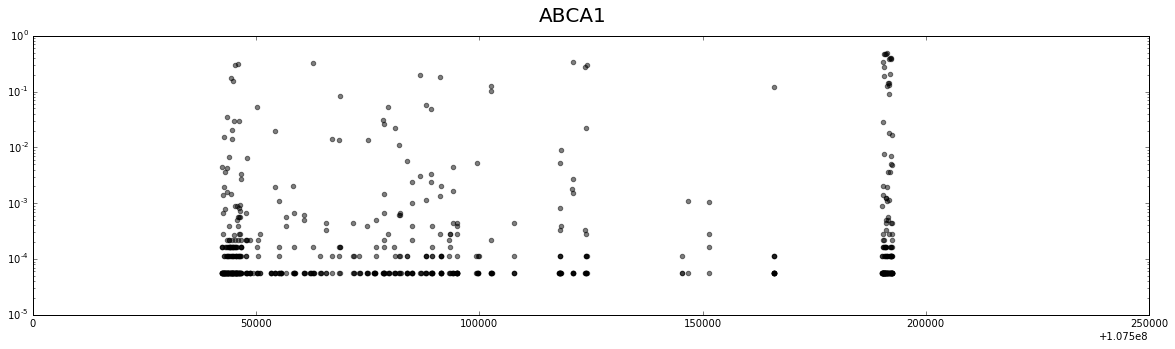

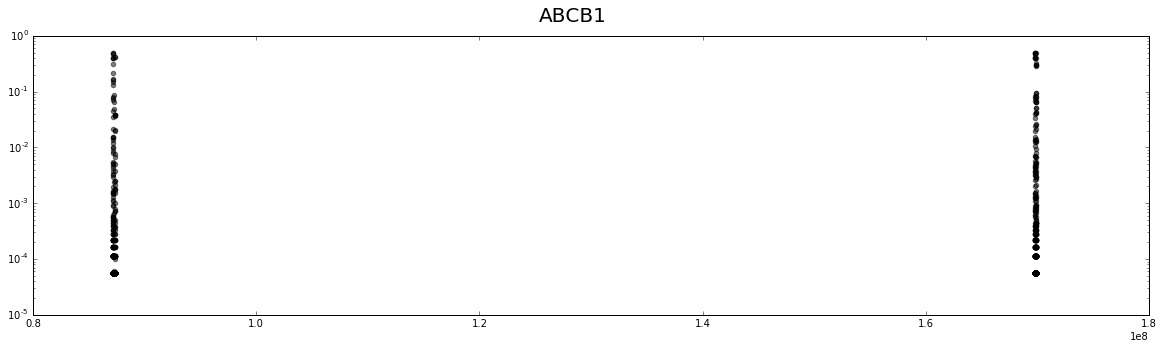

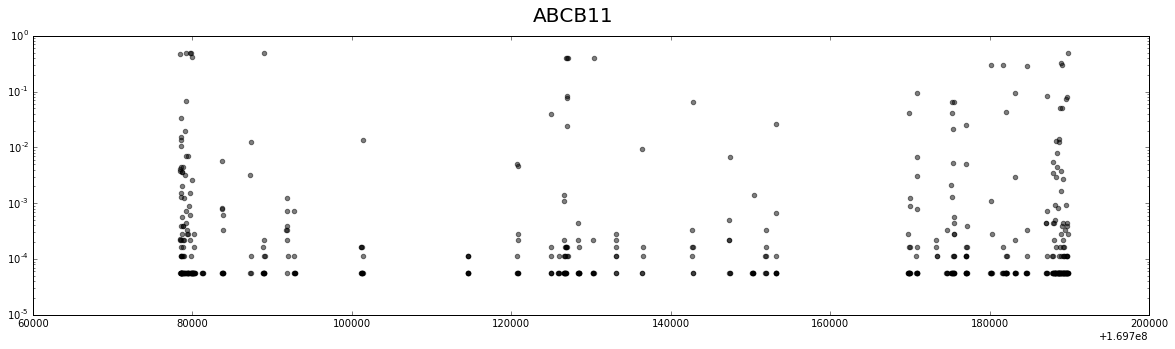

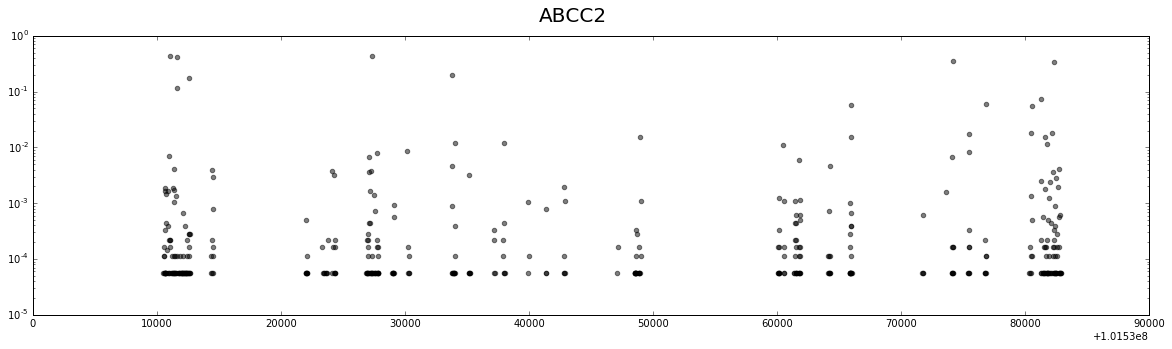

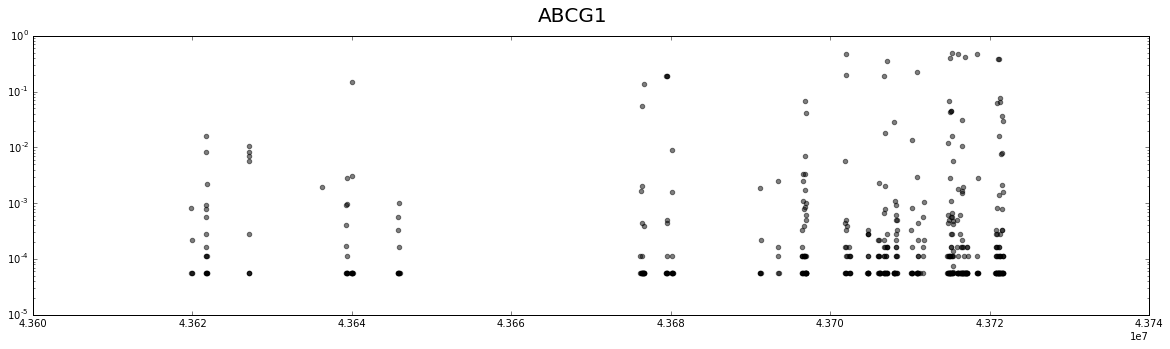

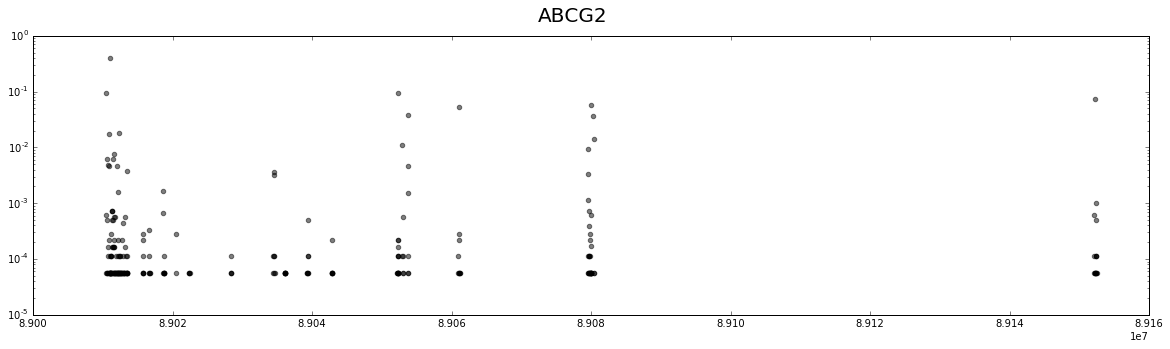

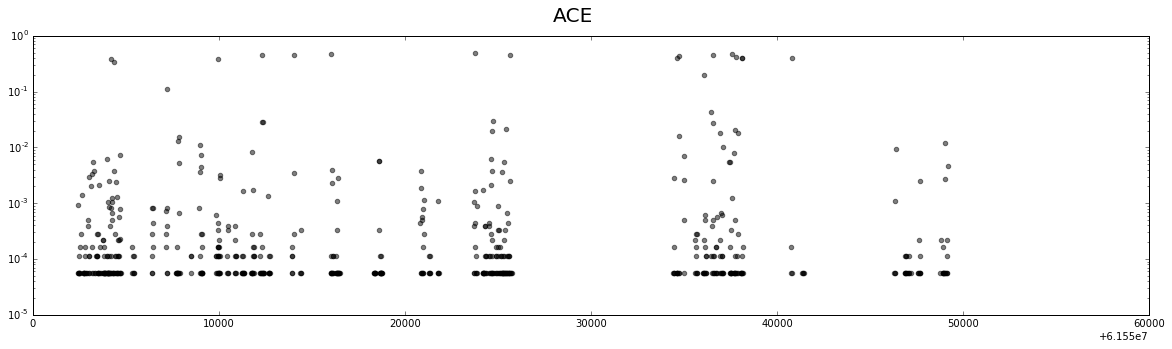

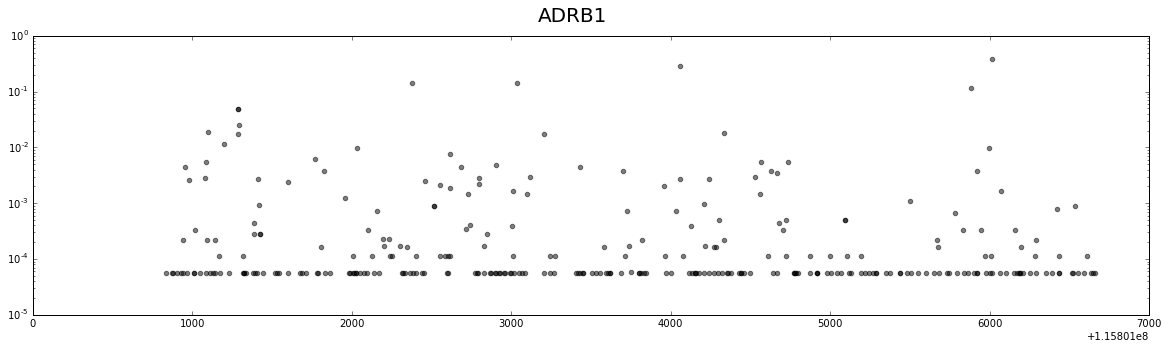

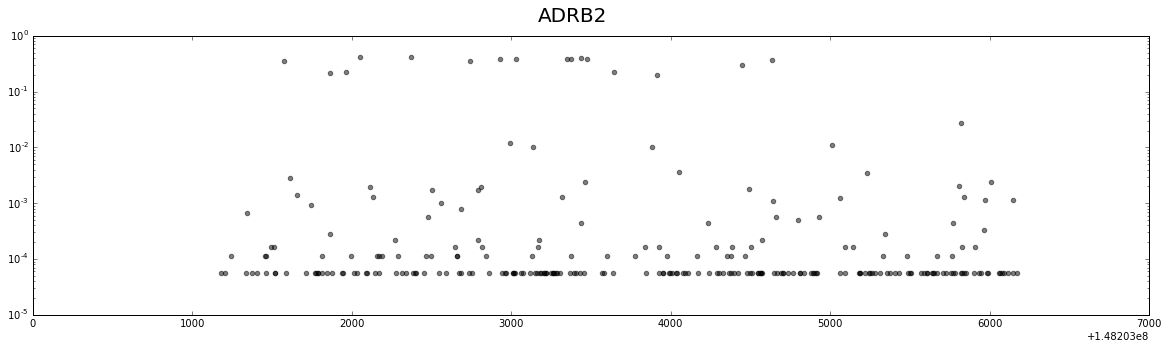

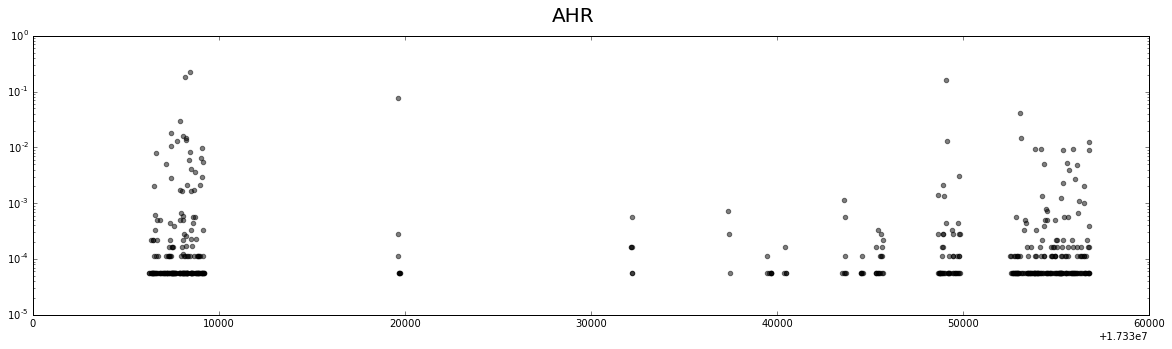

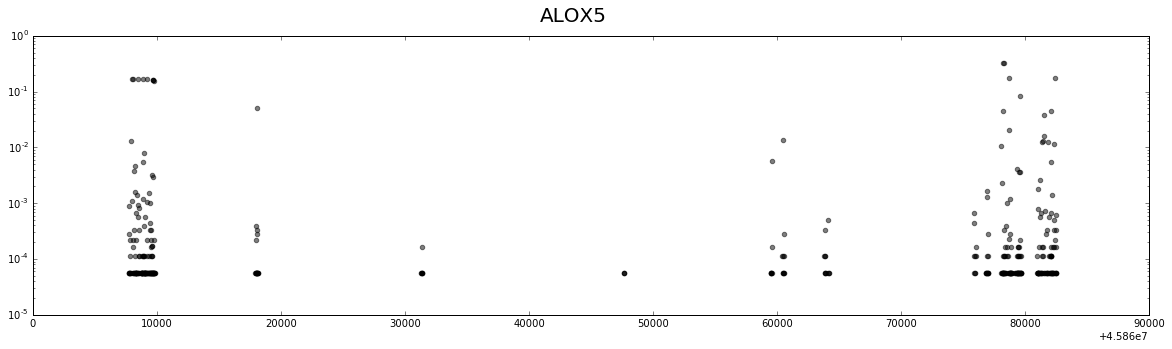

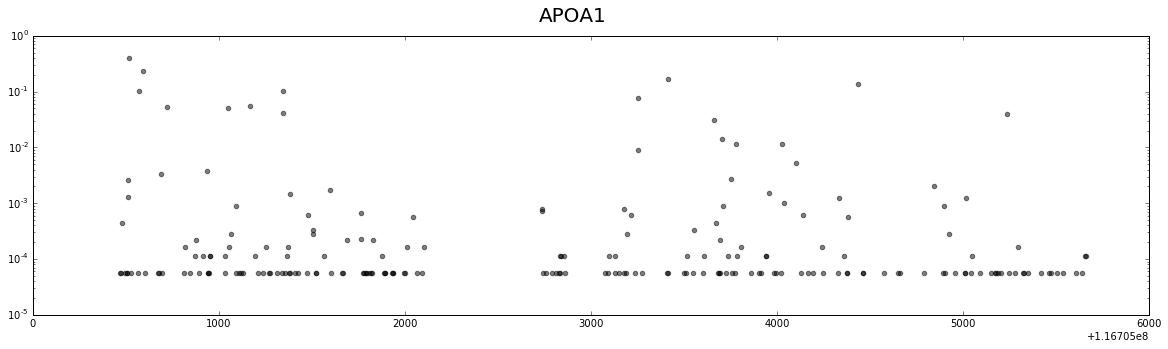

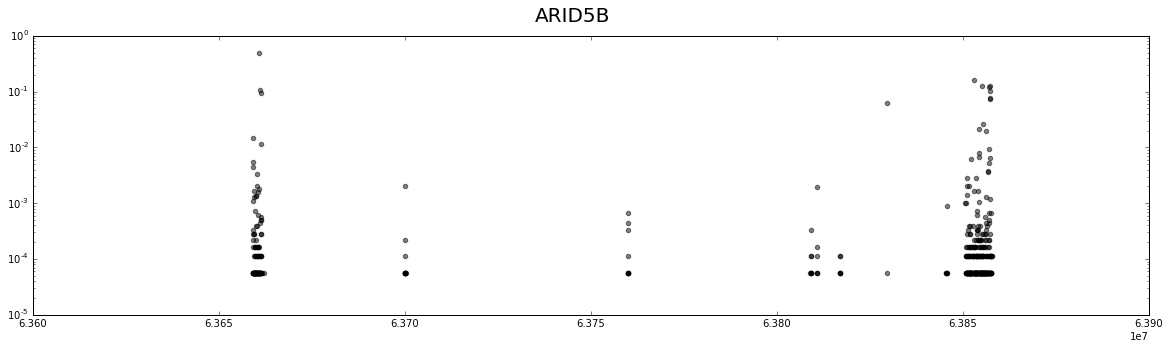

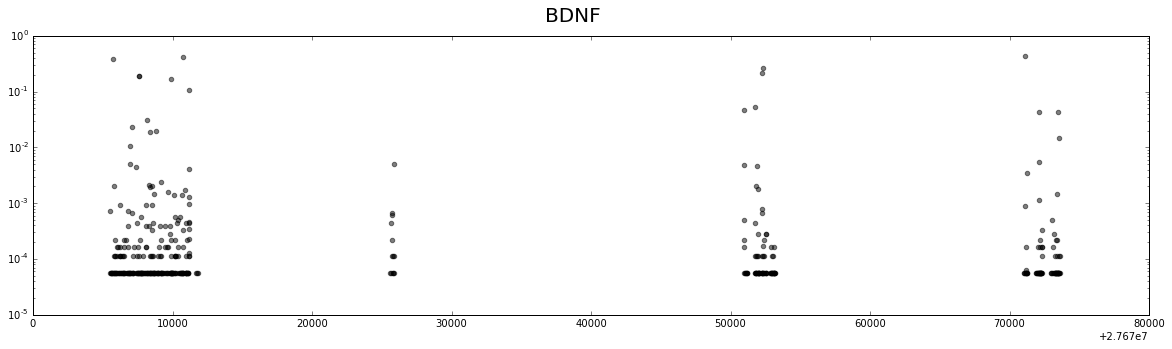

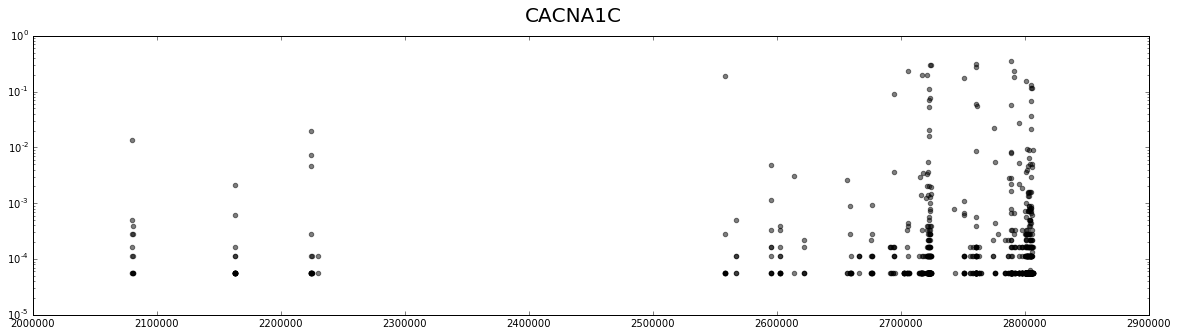

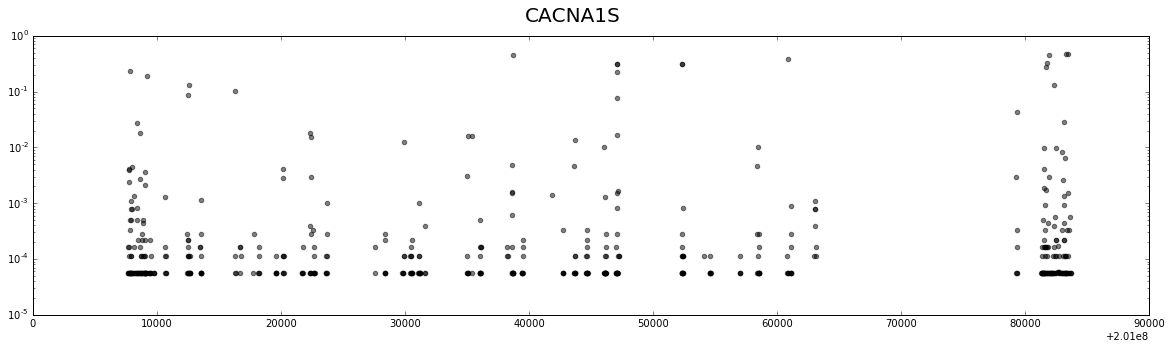

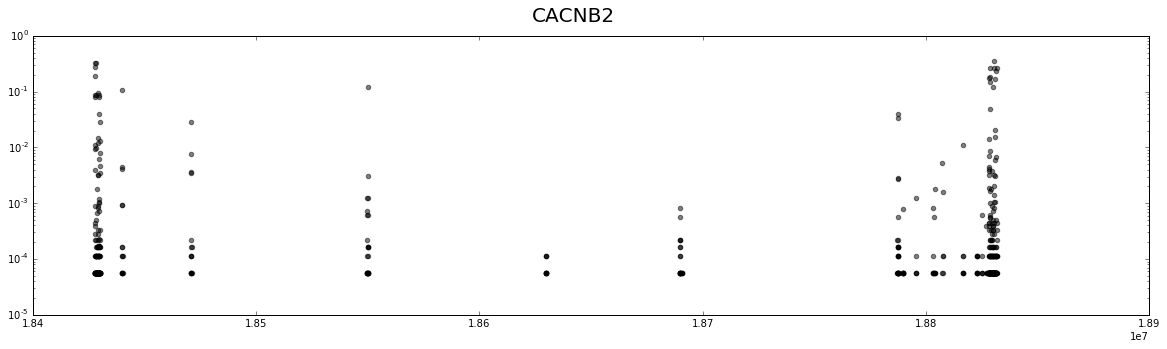

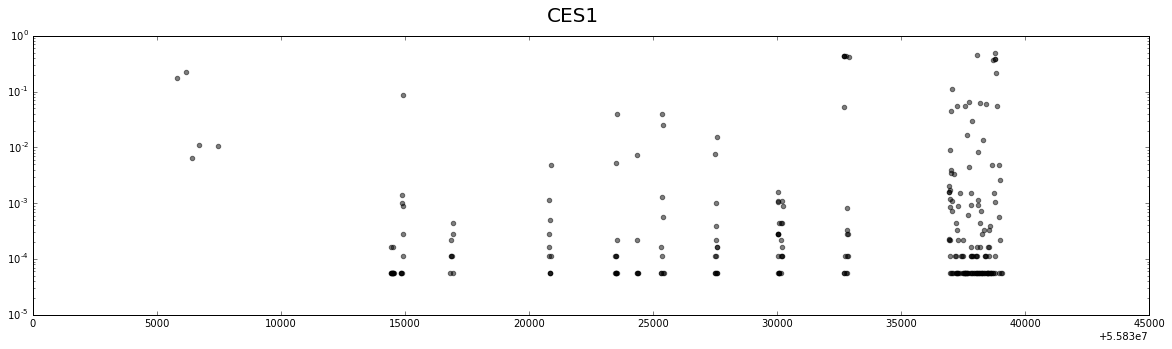

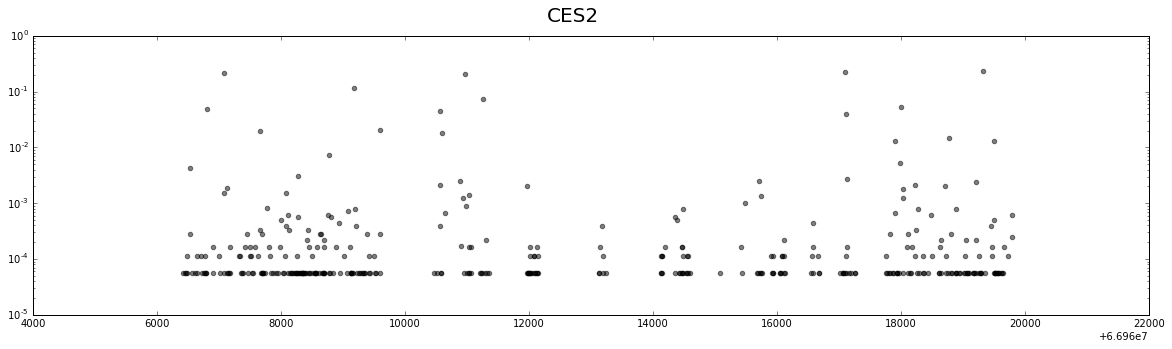

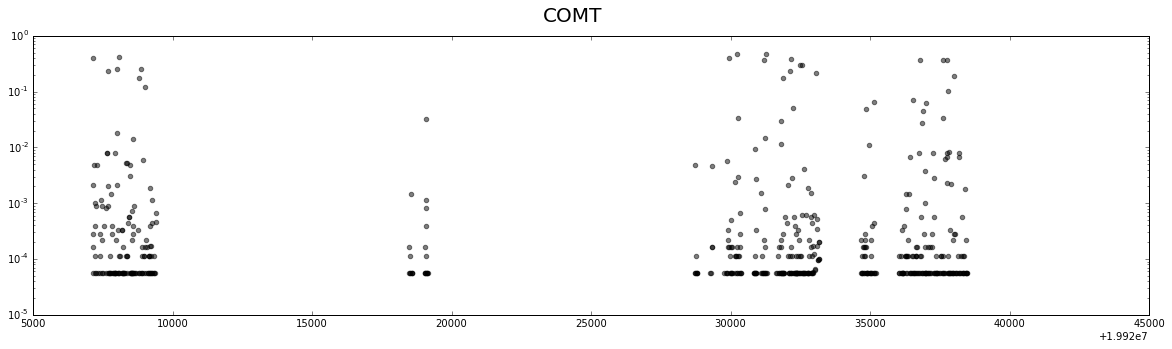

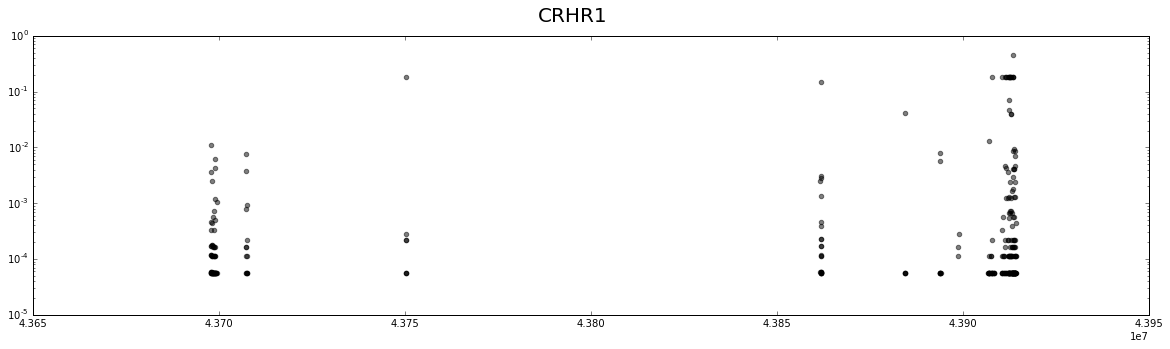

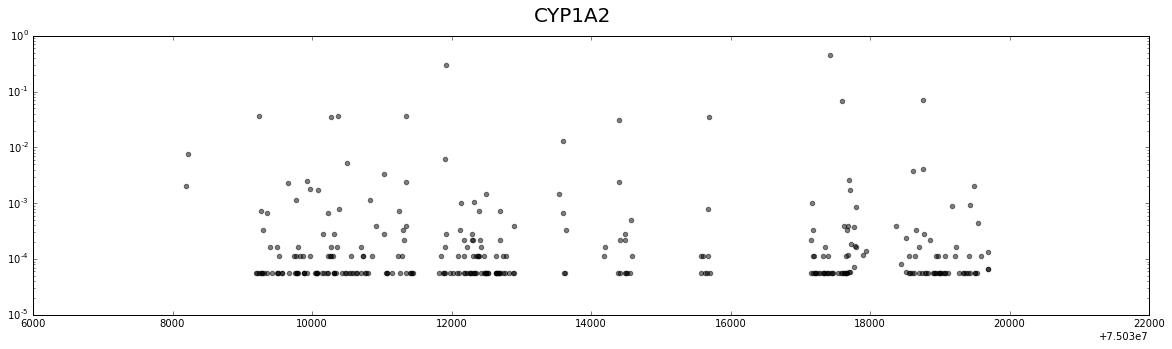

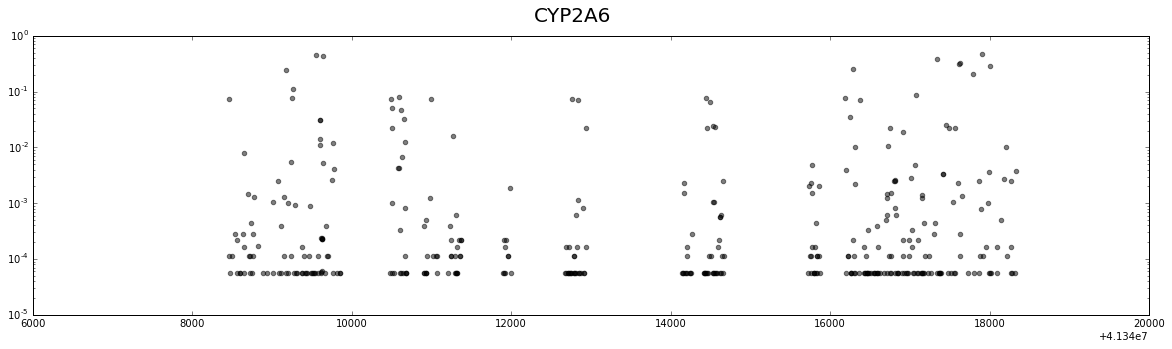

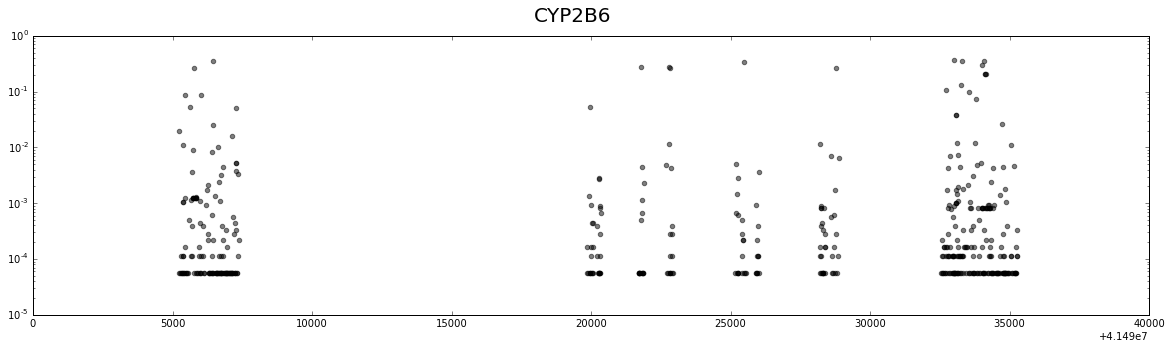

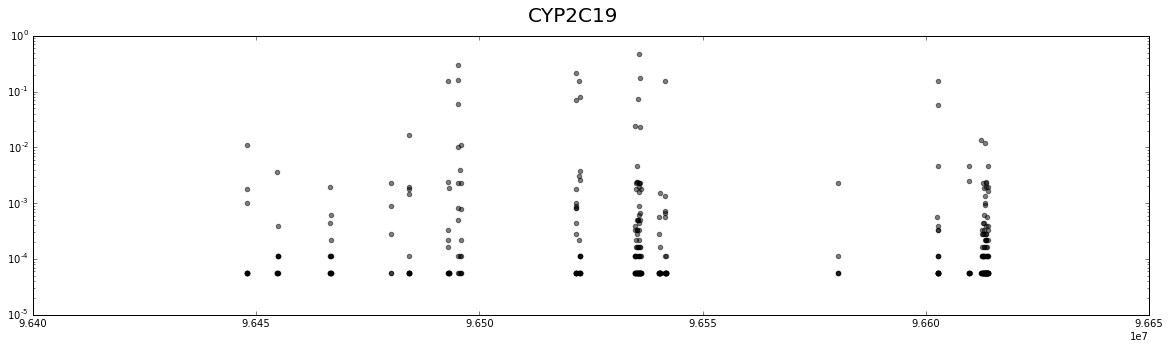

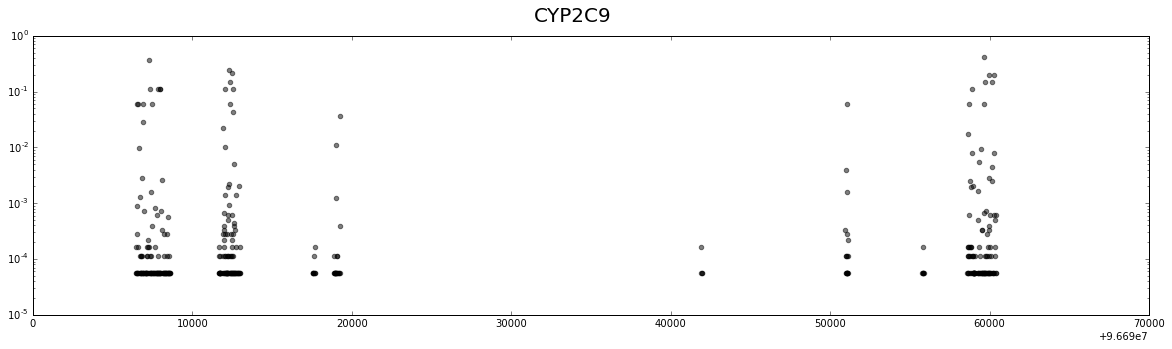

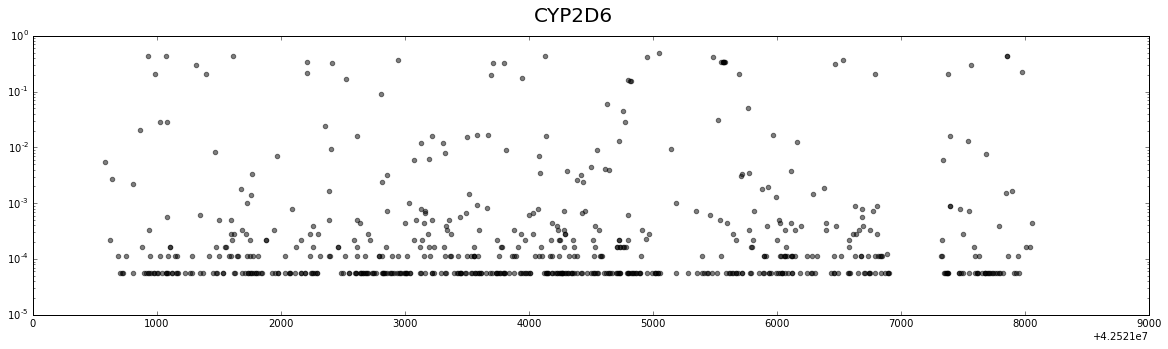

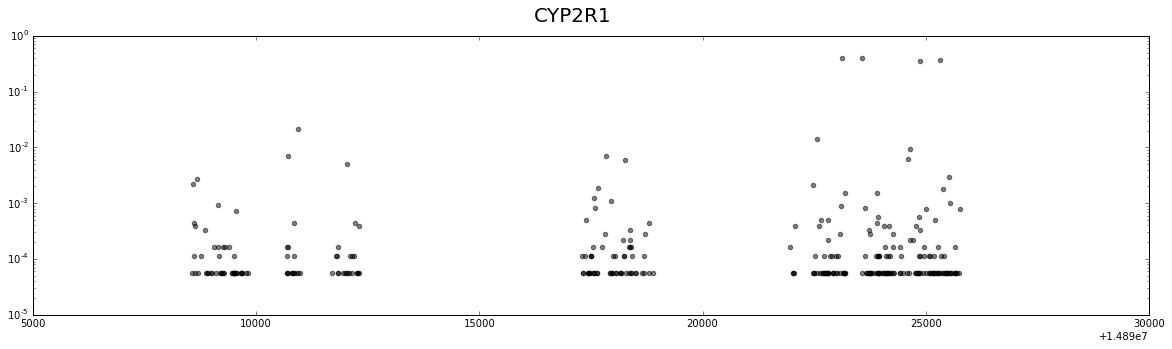

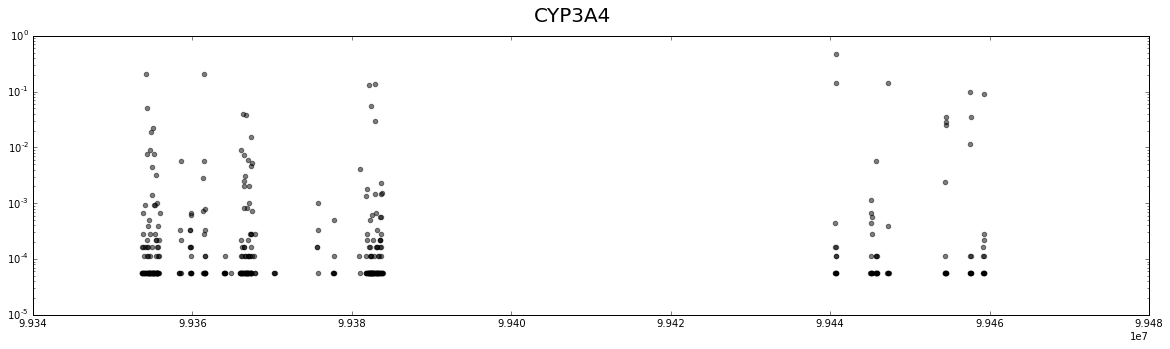

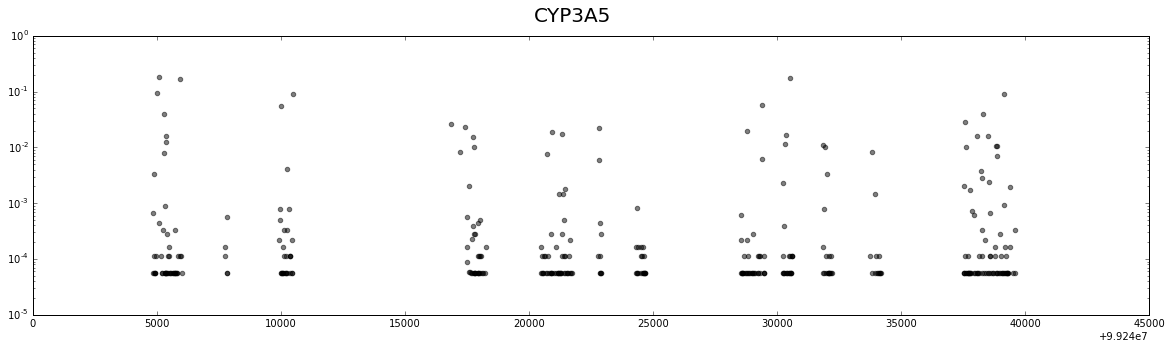

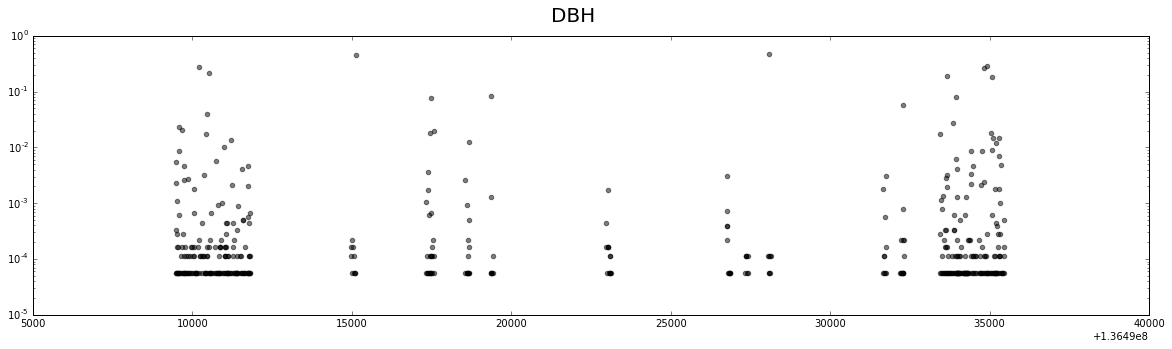

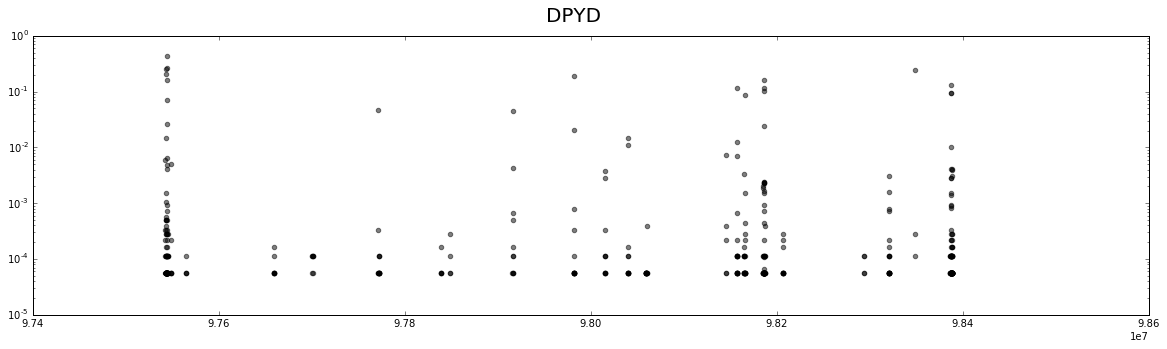

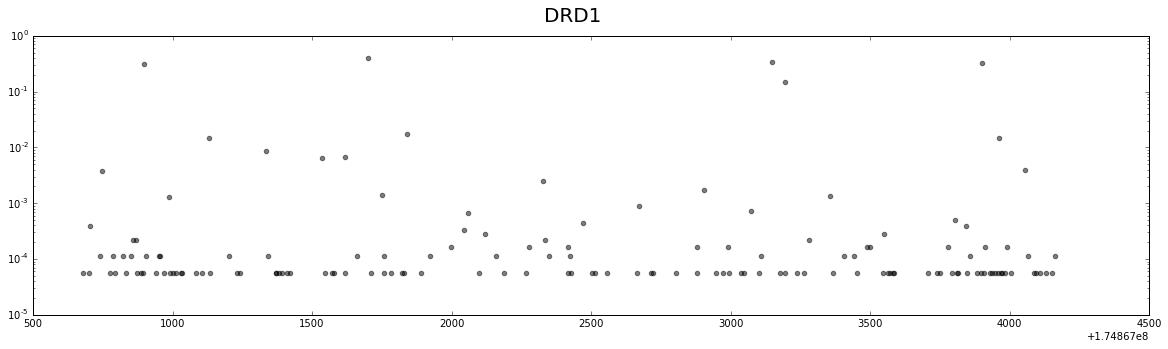

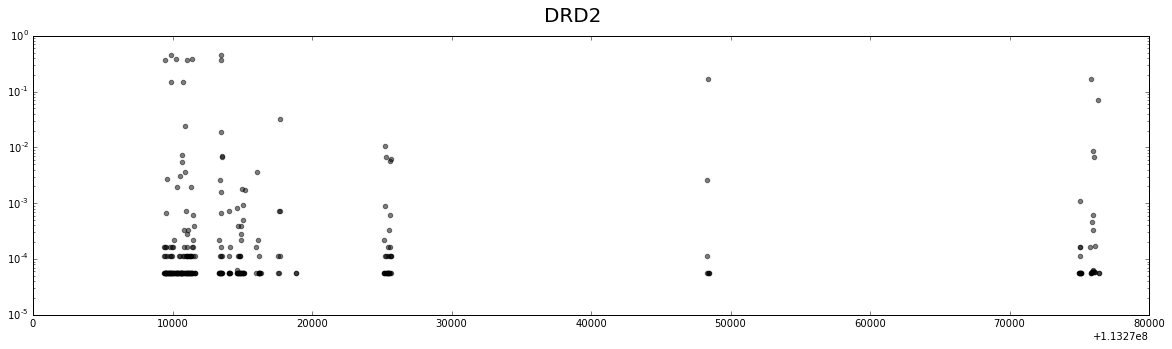

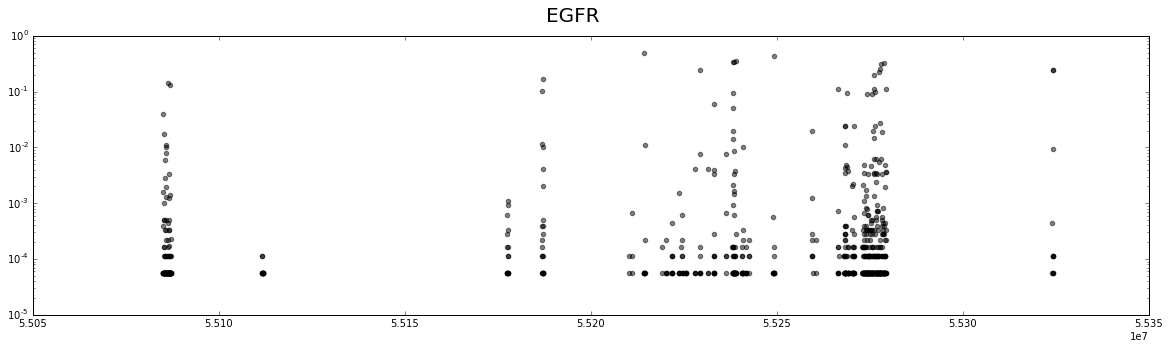

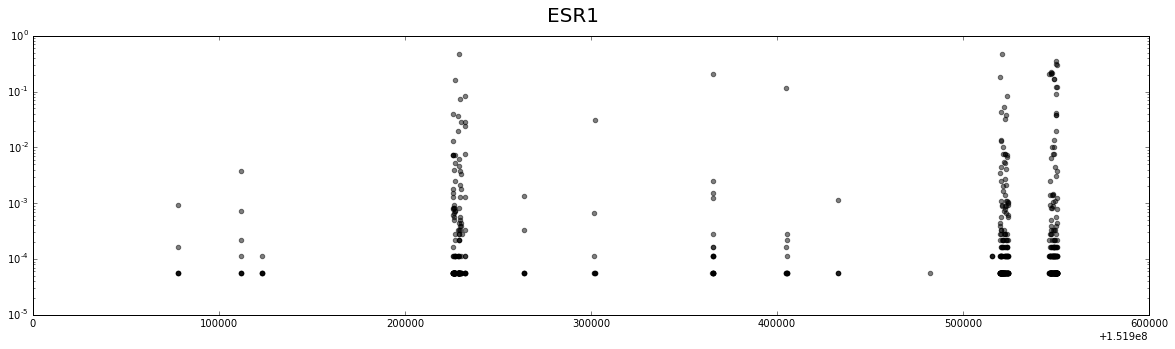

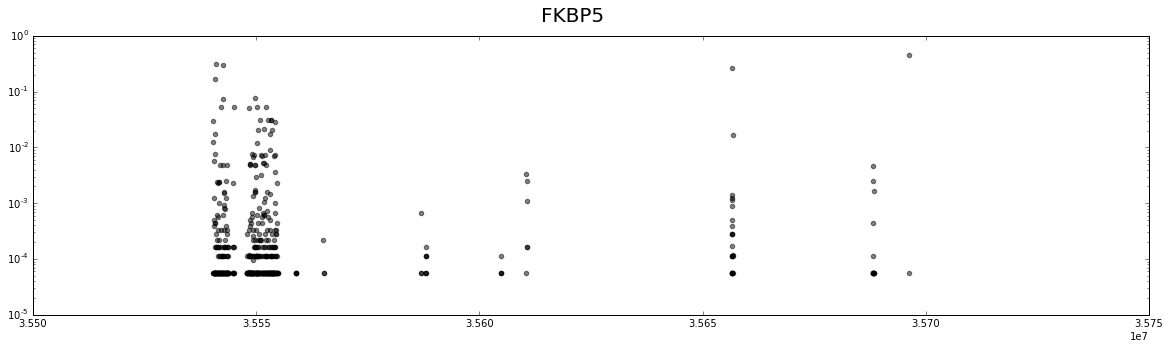

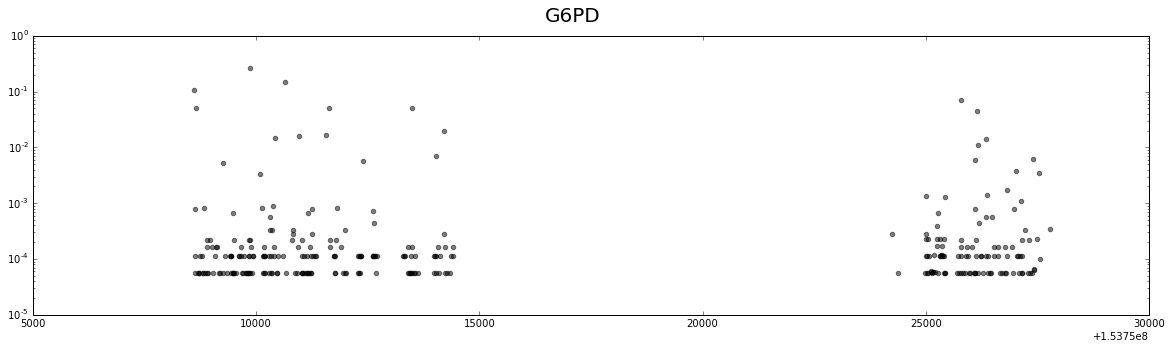

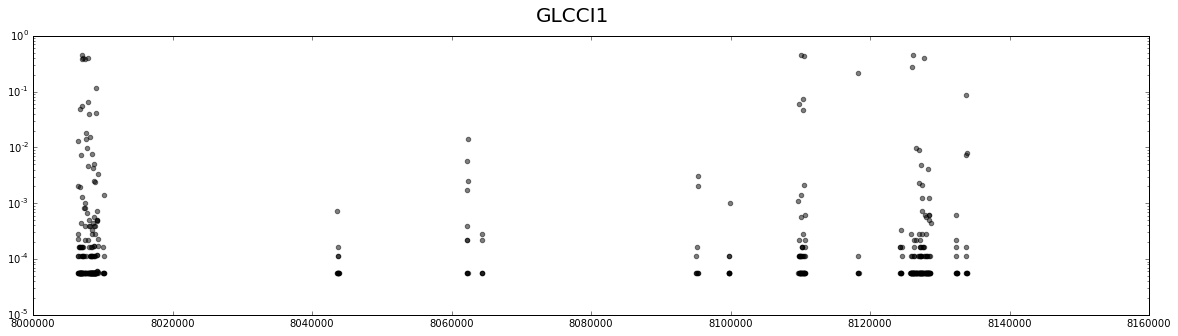

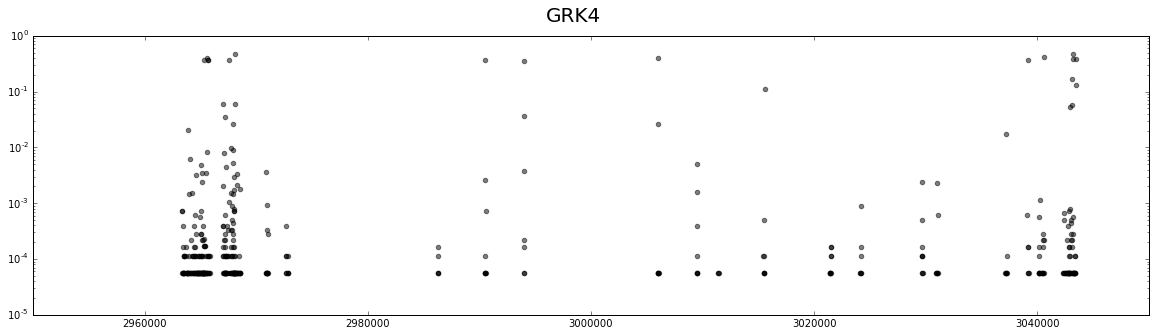

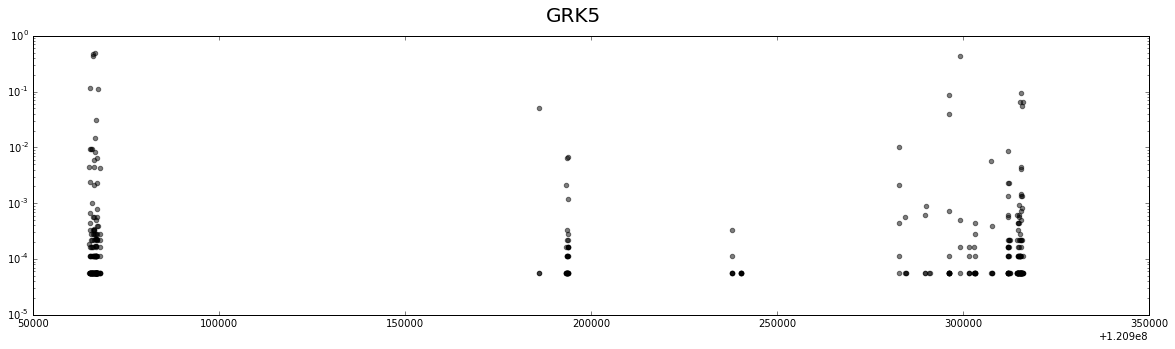

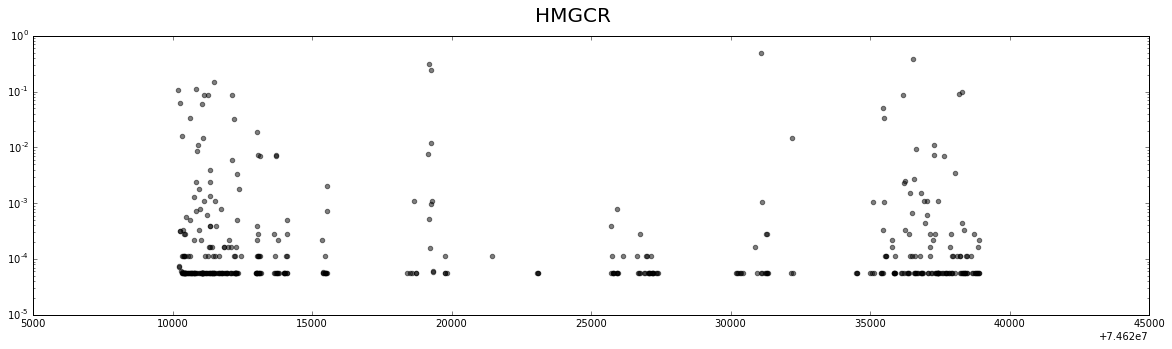

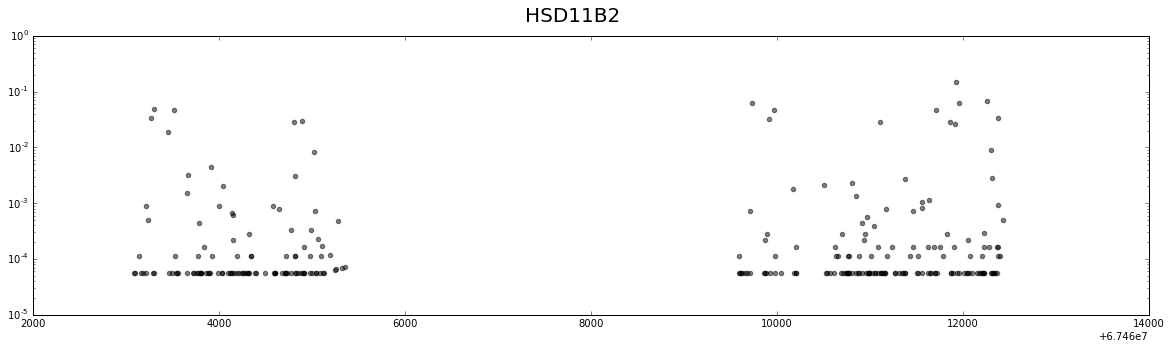

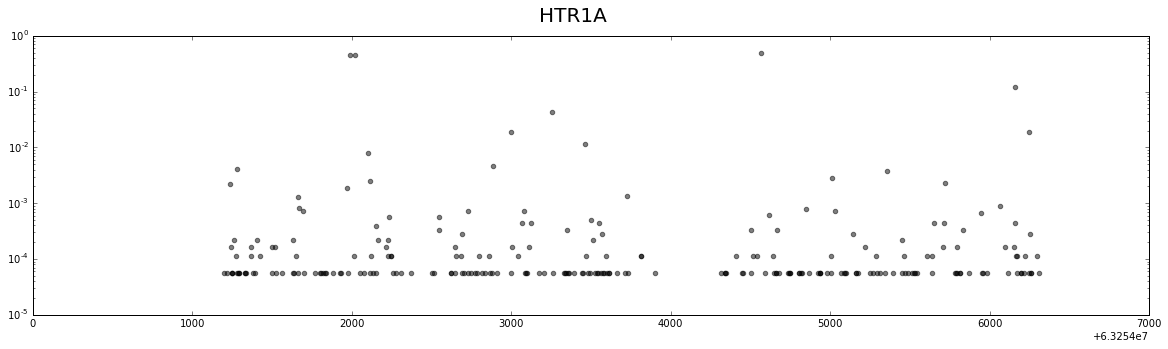

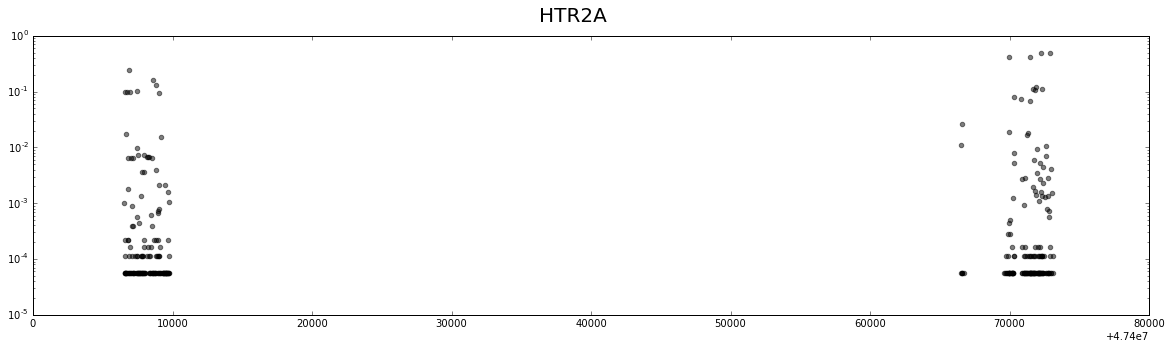

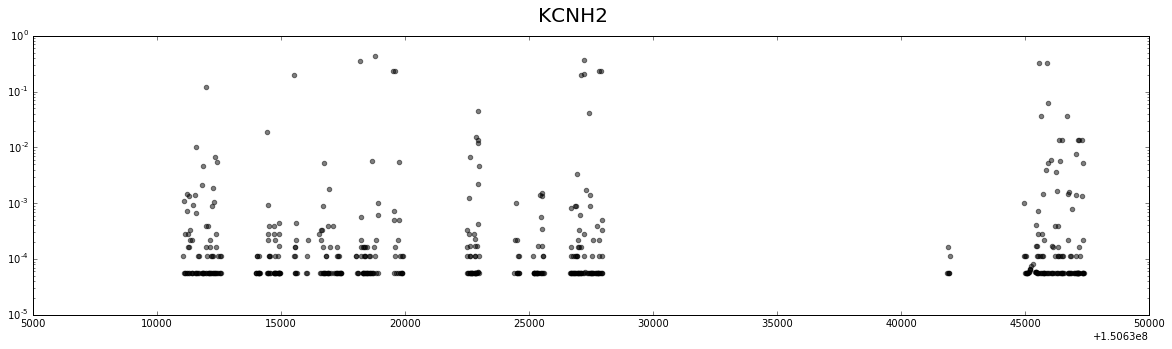

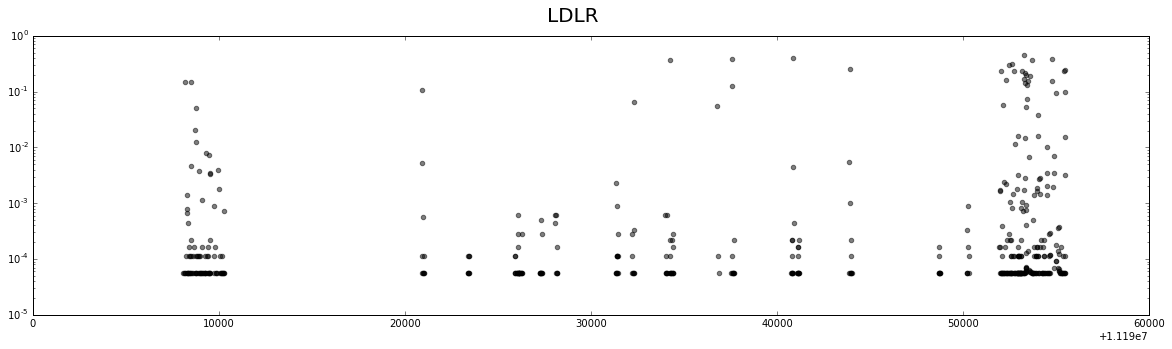

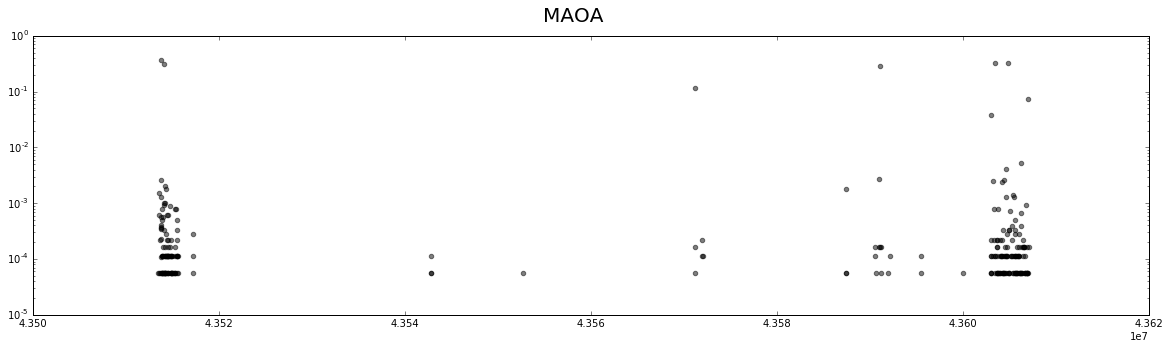

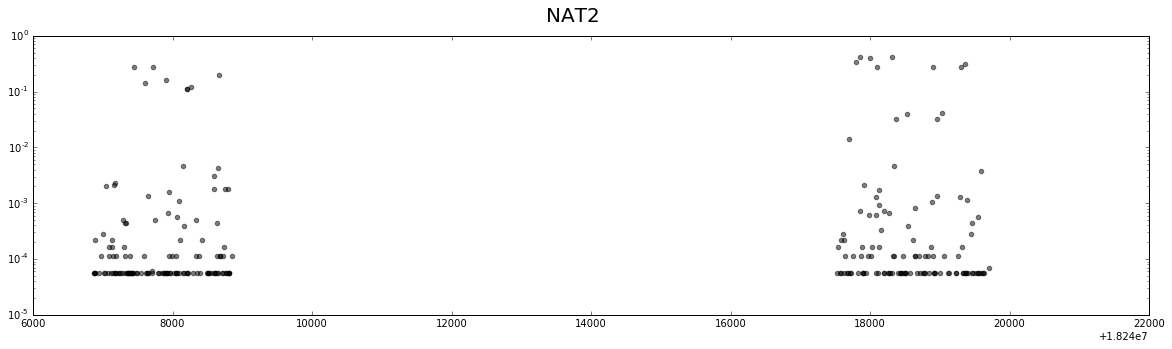

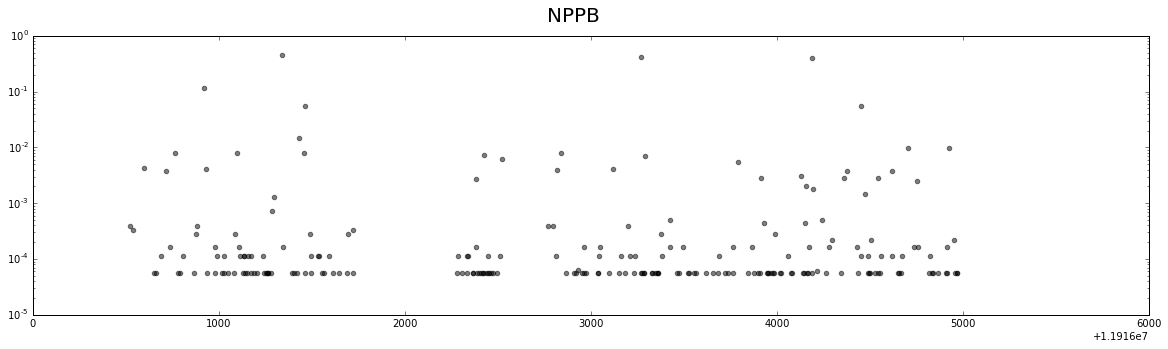

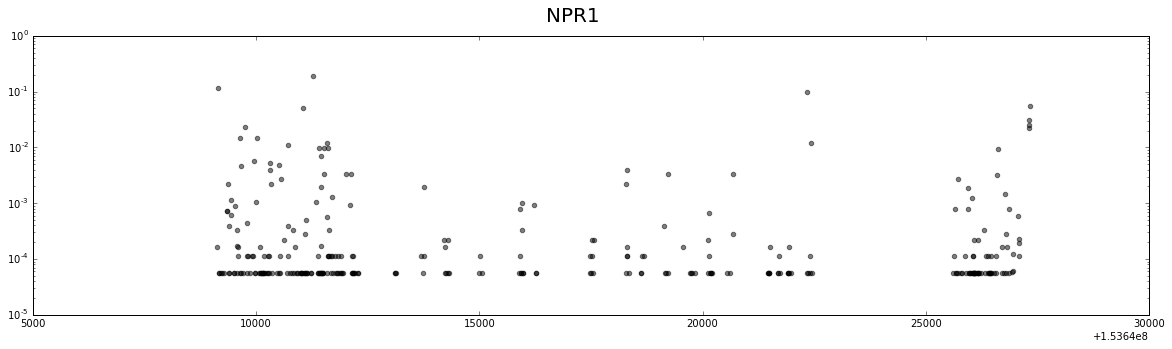

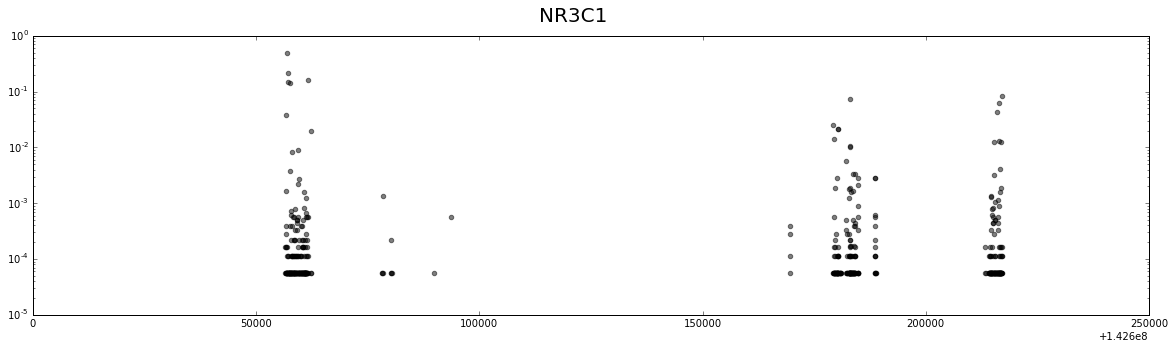

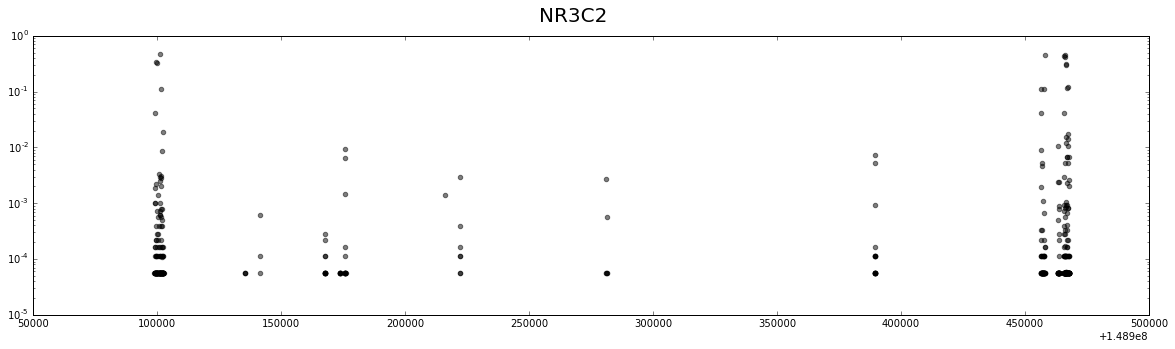

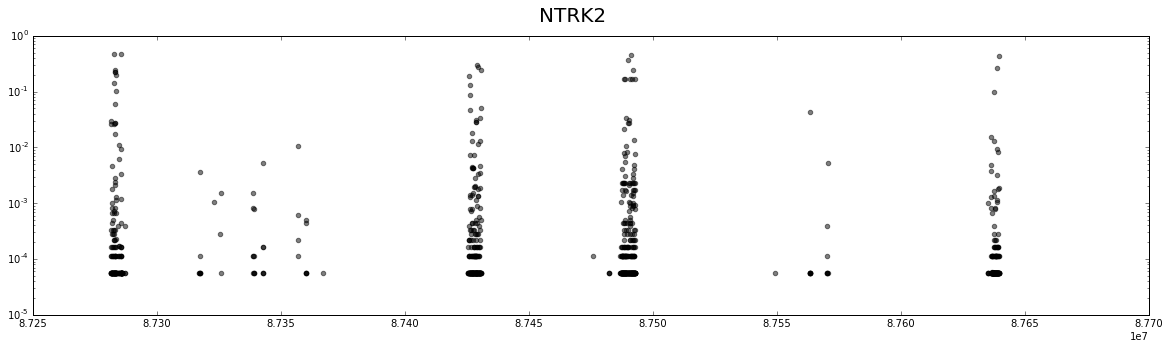

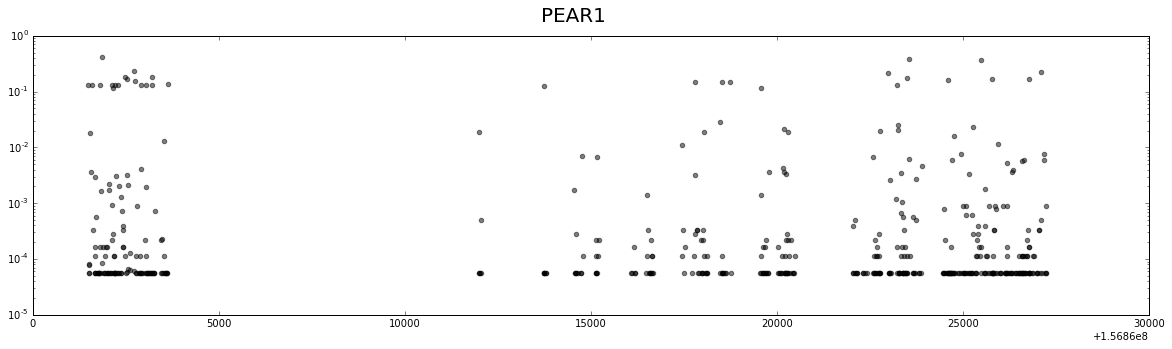

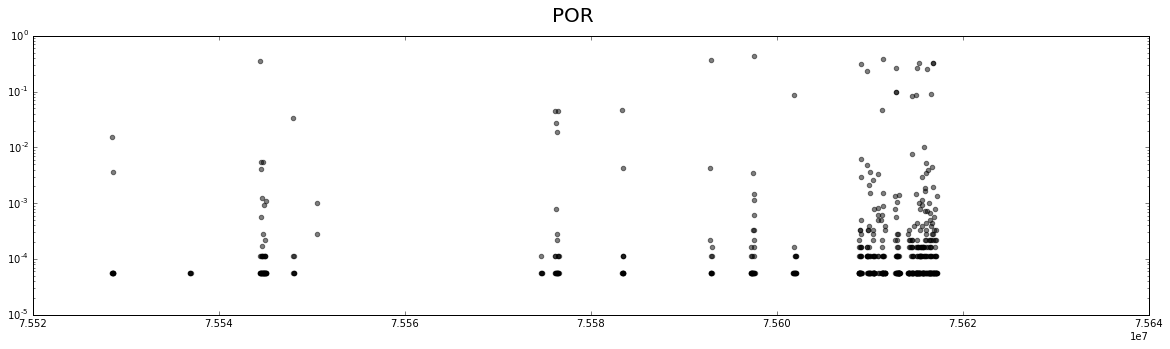

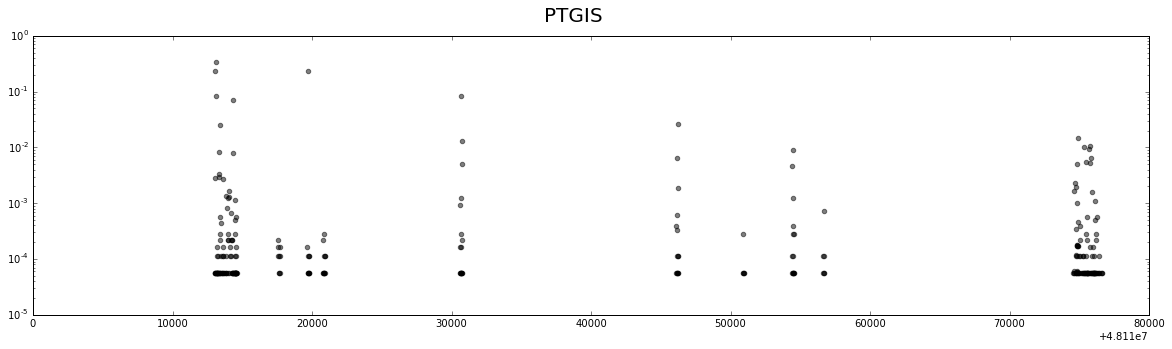

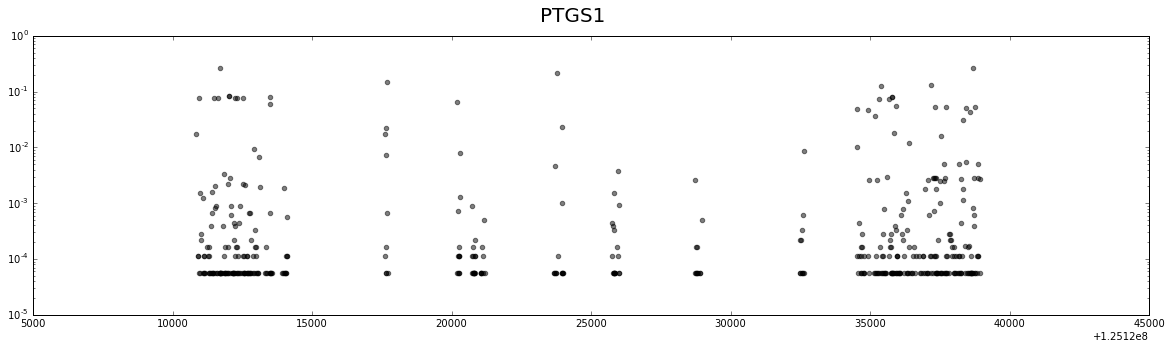

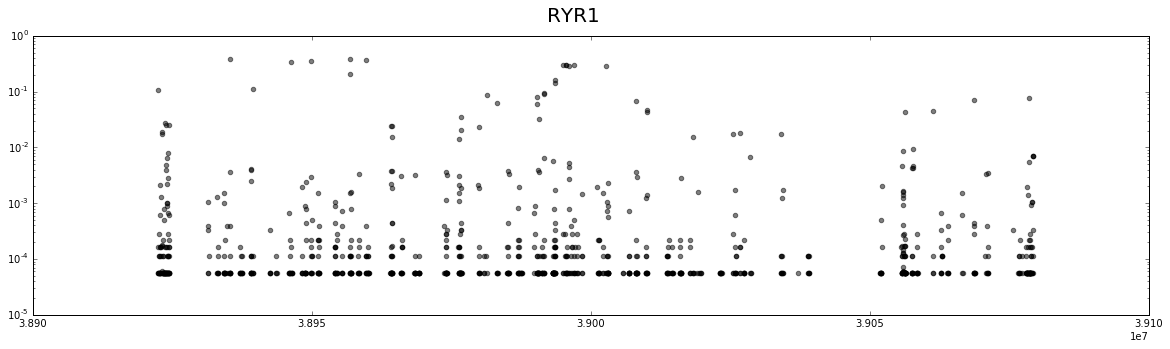

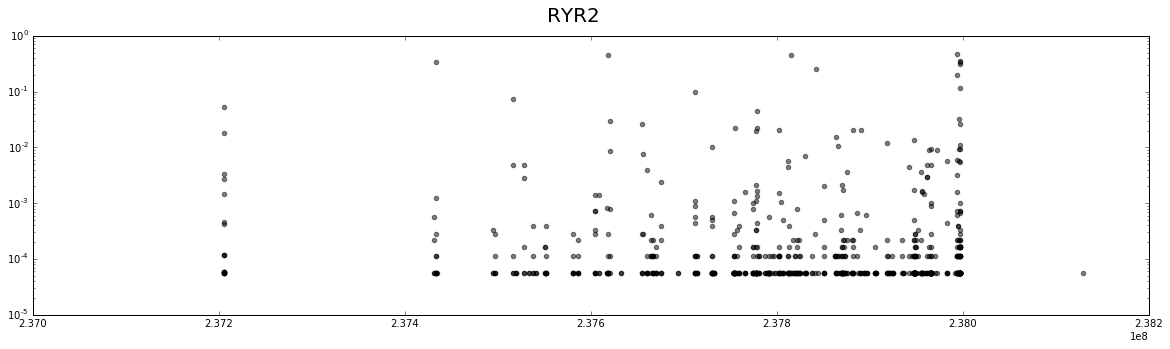

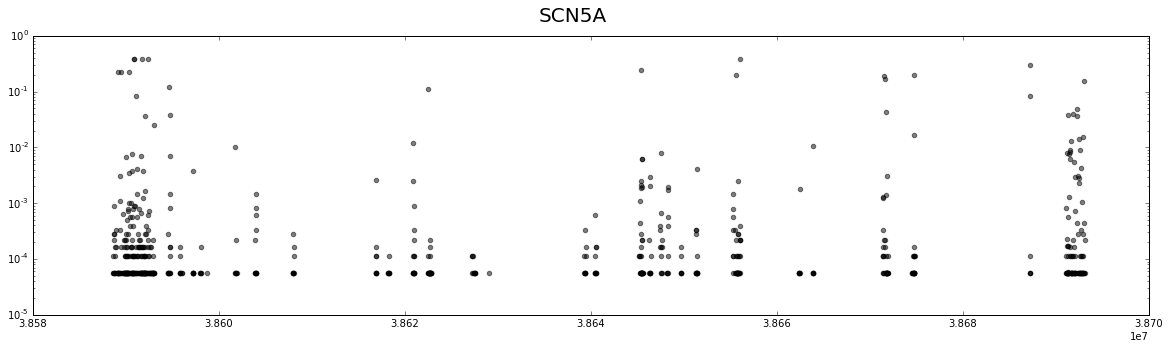

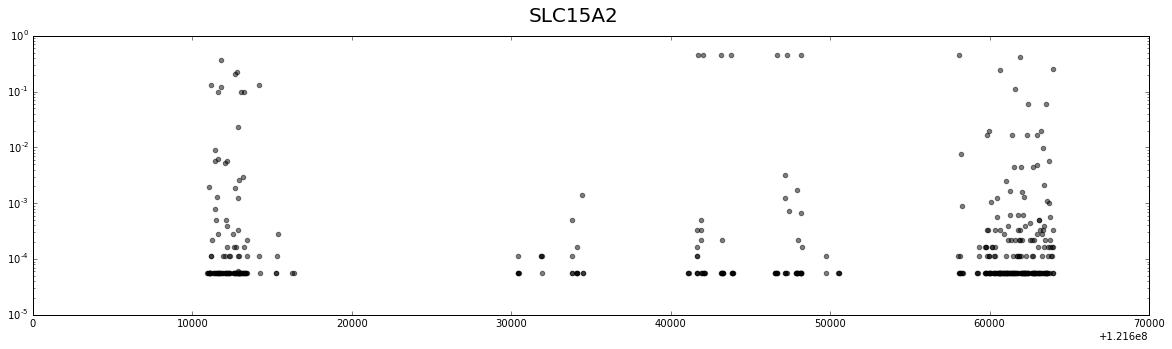

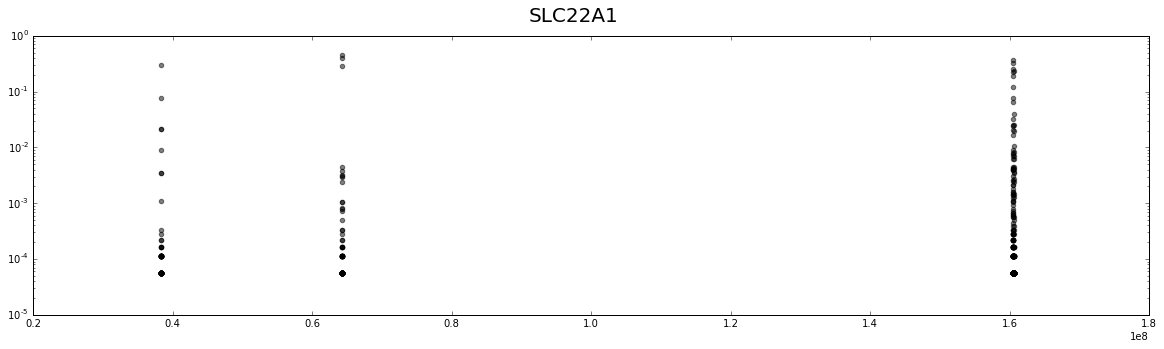

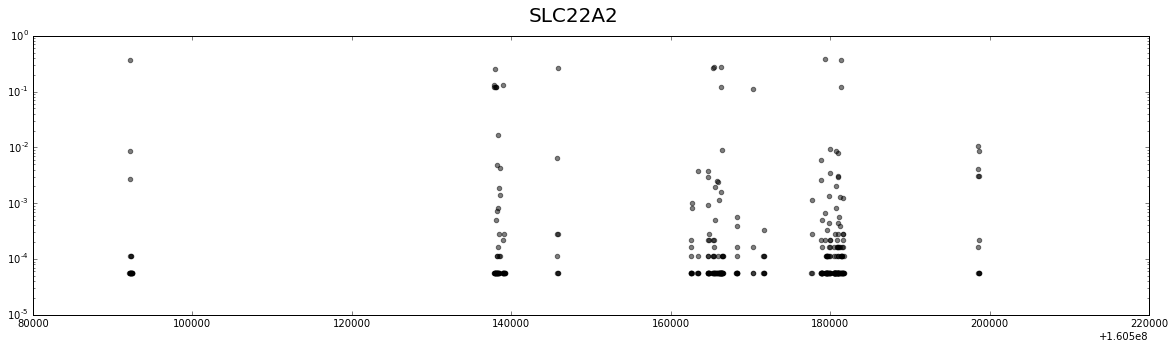

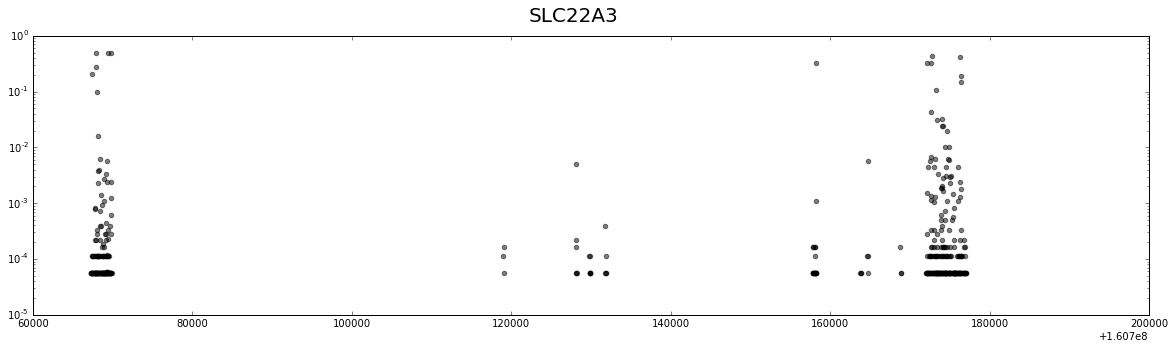

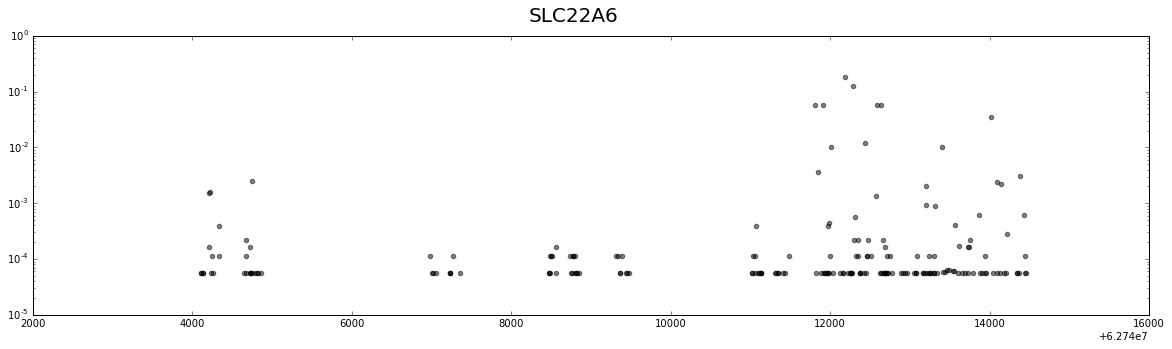

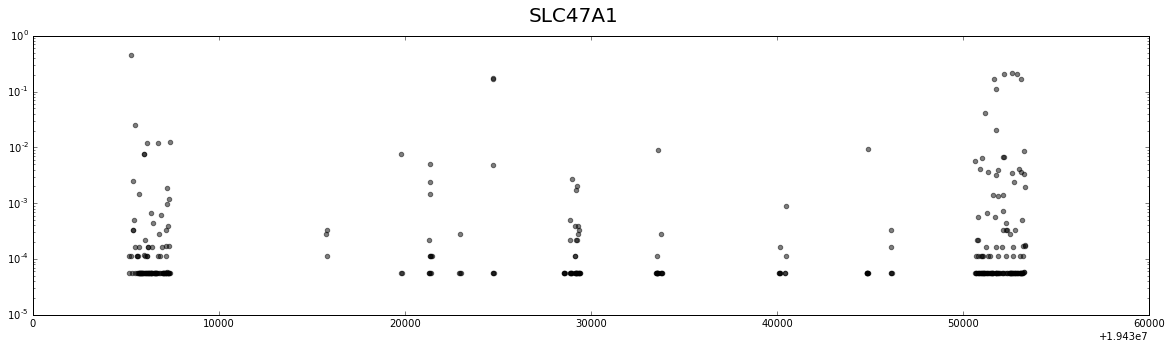

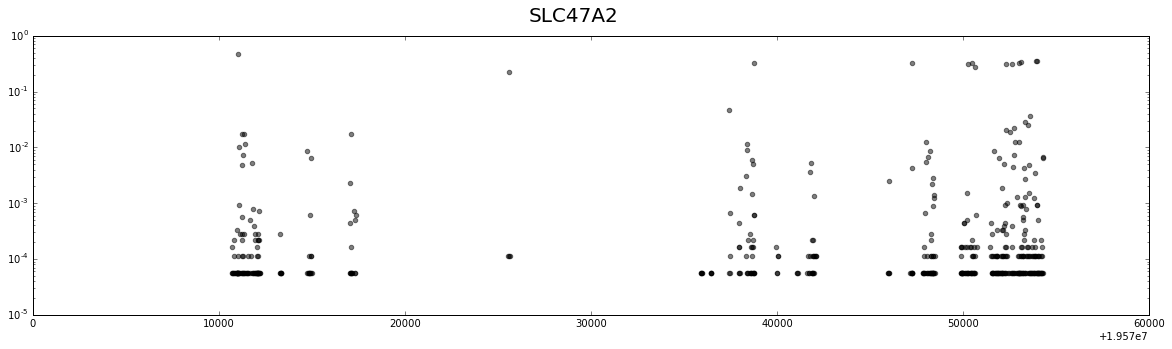

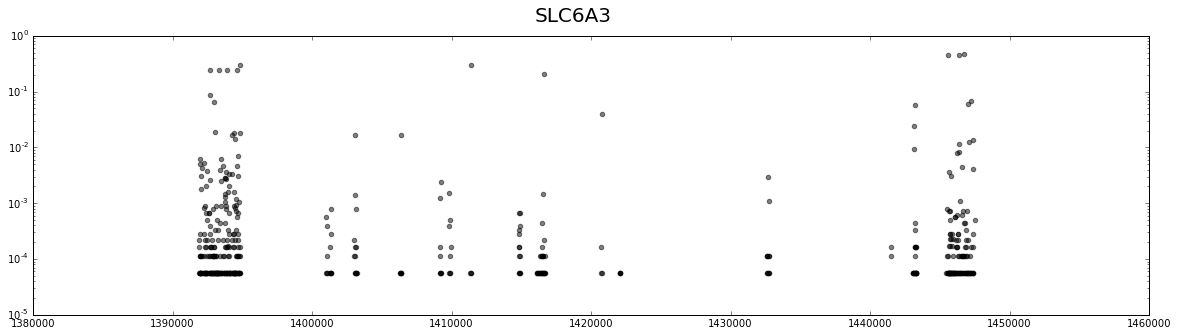

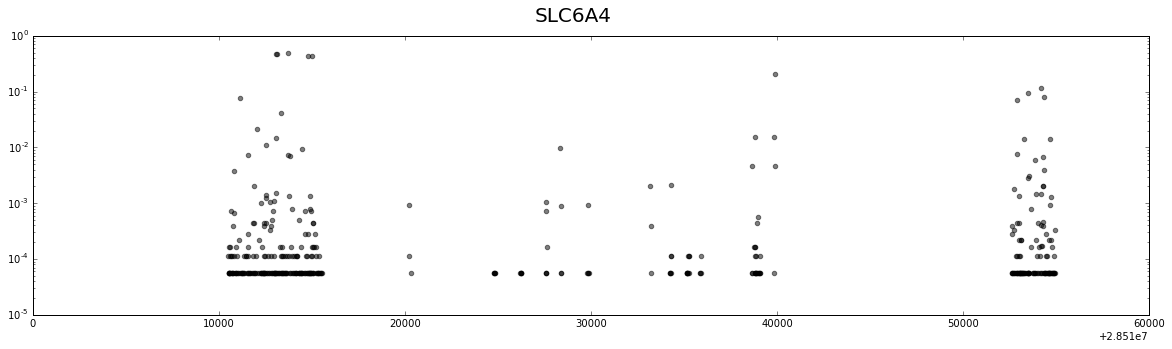

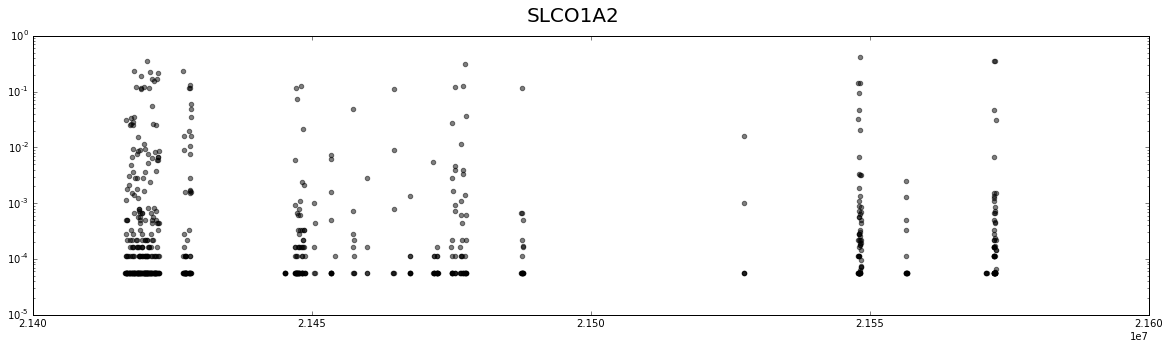

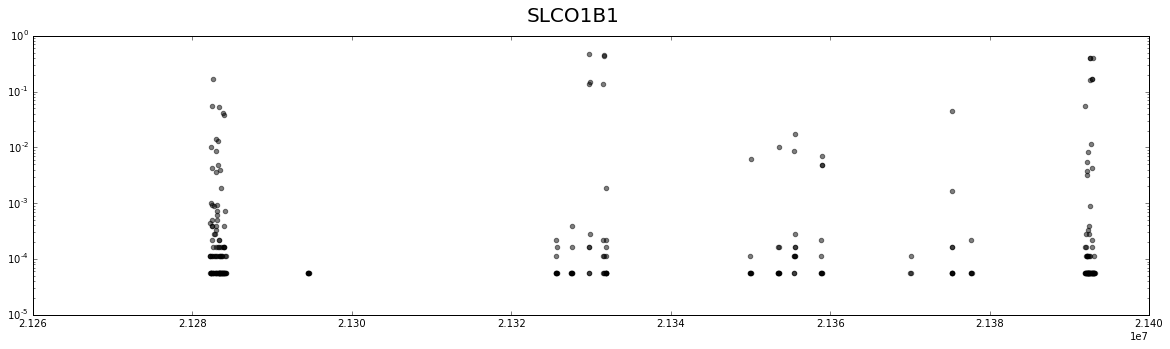

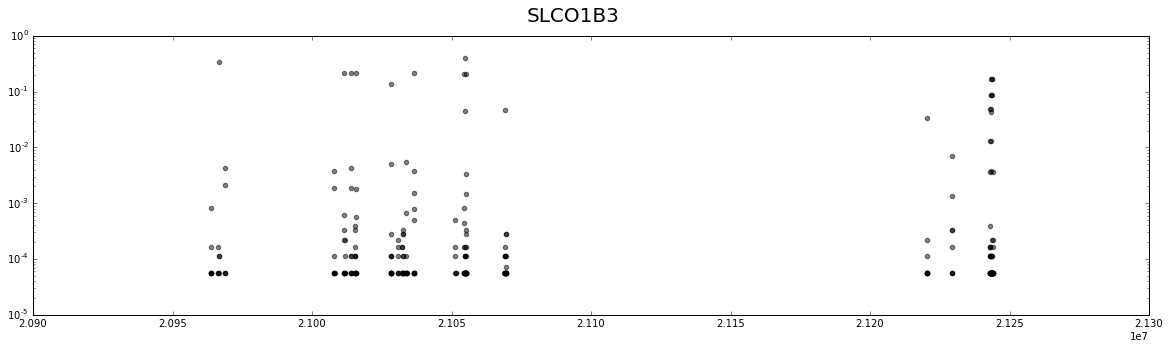

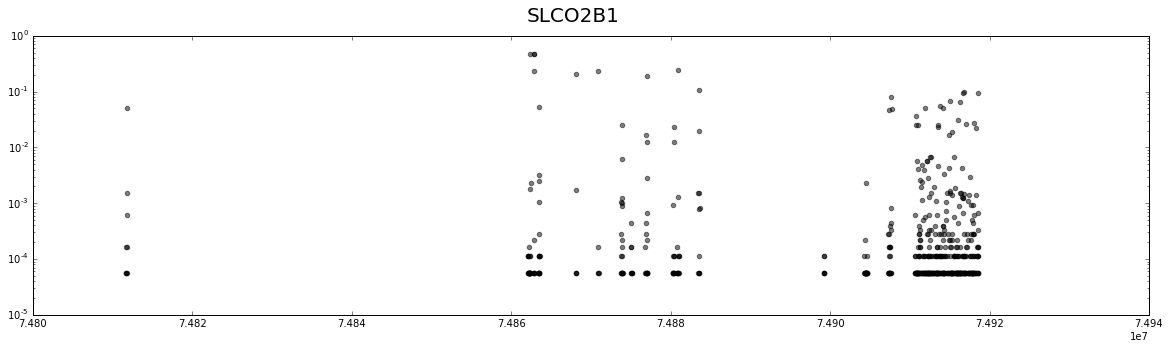

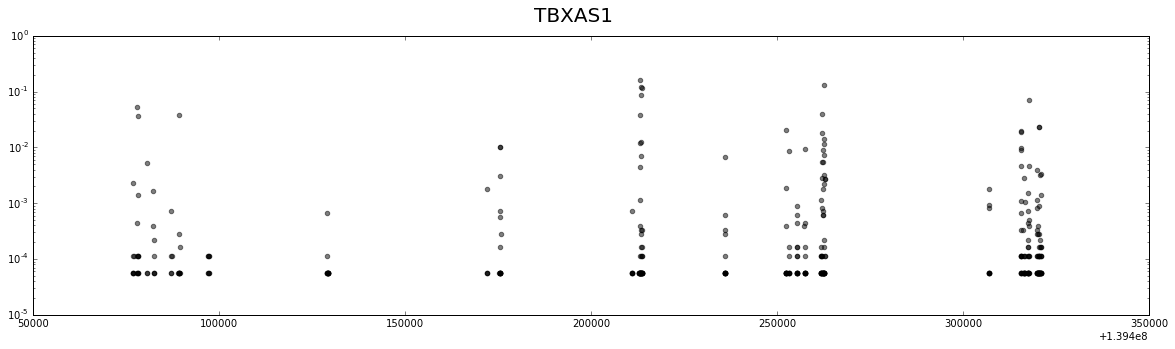

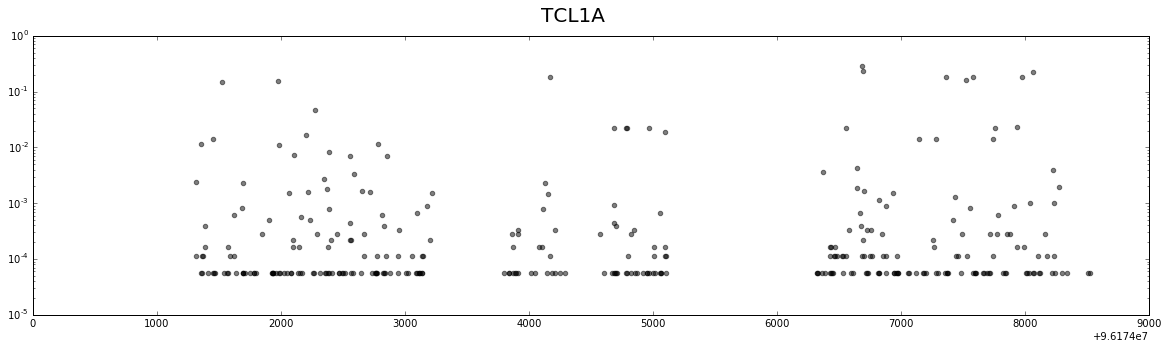

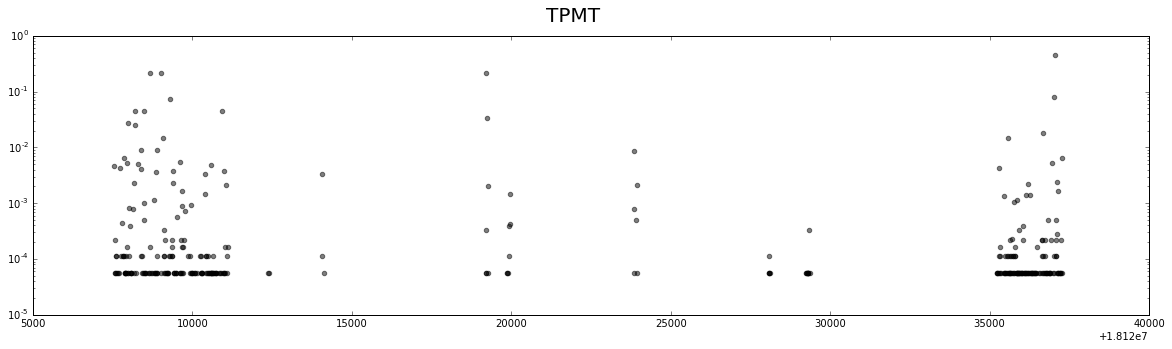

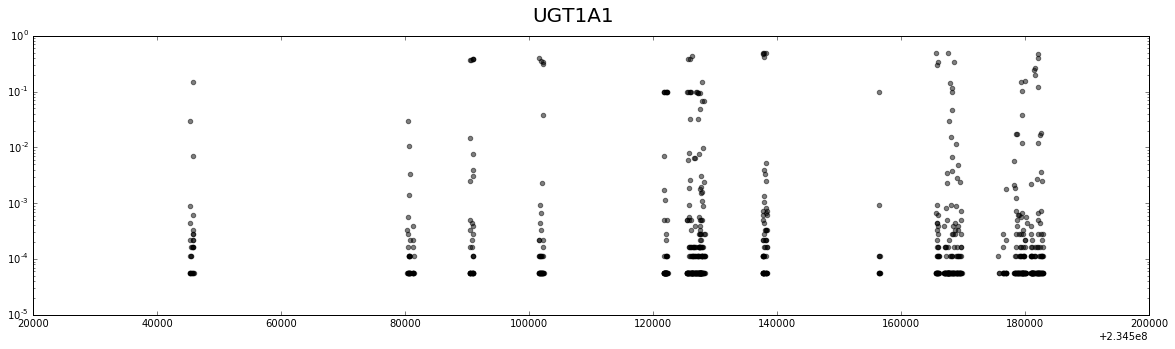

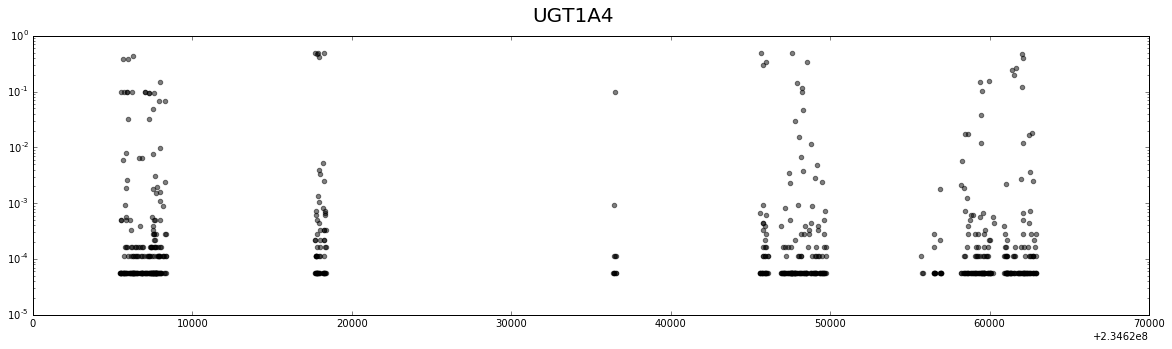

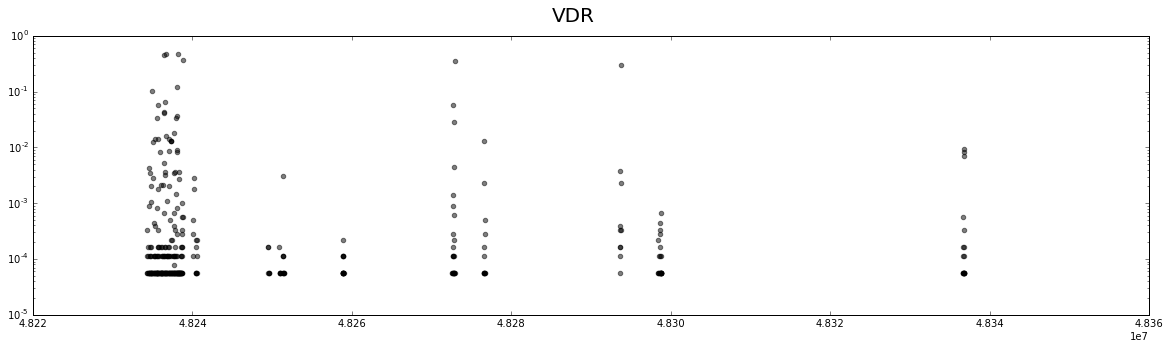

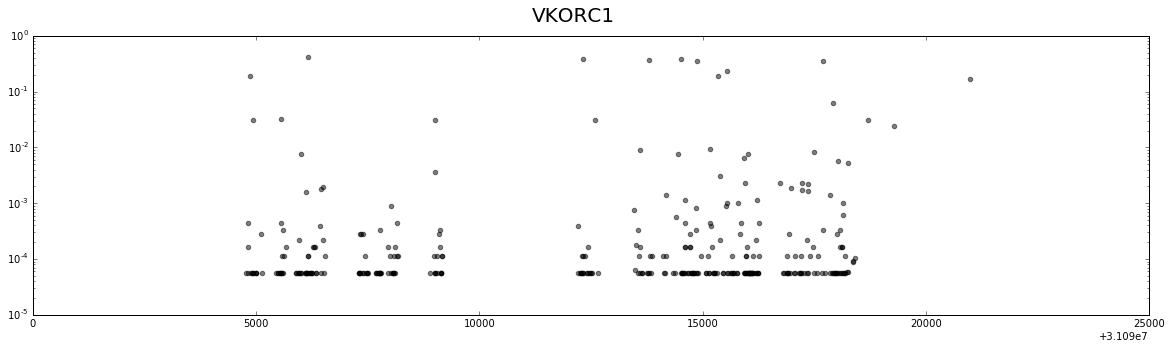

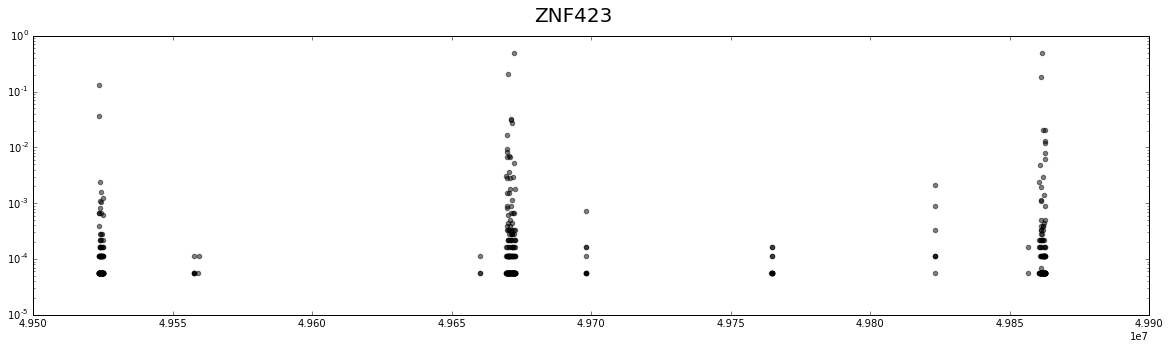

In [6]:
# plot global minor allele frequencies
# TODO: make this call plot? to here or to plot.ly? or just return the figure data? or both?
plot_genes(alpha=0.5);

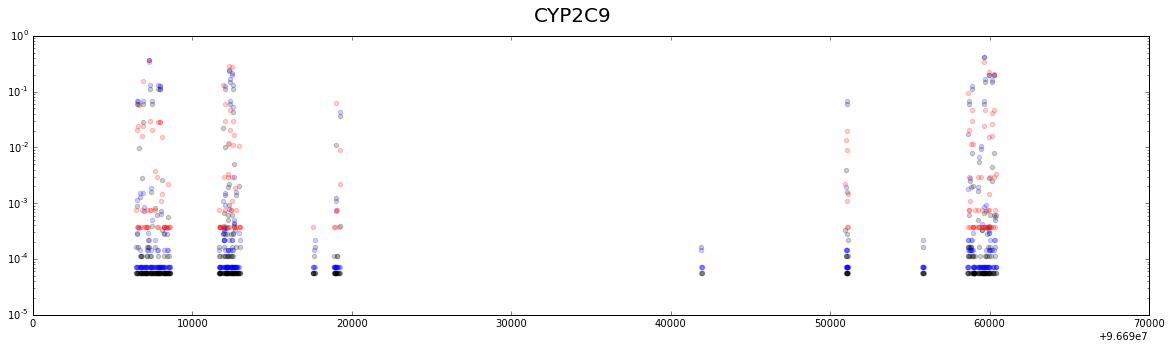

In [7]:
# TODO: this plots twice without the ; -- good or bad? (see above cell)
plot_gene('CYP2C9', POPS, alpha=0.2);

### Plotting with graph_objs

this is the plot.ly way using graph_objs, which seems to be more convenient, but is limited to 30 requests/hour (or 50/day). Alternatively, it is possible to use plotly.offline.plot to bypass the limit.

In [8]:
# TODO: check that no rsids are missing, though the numbers look reasonable
def color(snp):
    """ Variants with an rs-identifier are circled in red. """
    if snp['rsid'] == '':
        return 'black'
    return 'red'


# TODO: would it be better to destructure plot_data instead of using the tuple accessor functions? how? mb sth like list(zip(*some_data))
# order of dict keys/values/items is actually guaranteed to stay the same (if the dict is not altered), so mb just use different variables
# TODO: rename this to something more meaningful - manhattan plot?
def plot_gene(gene, pop='global'):
    data = DATA[gene]
    # x, y, rsid, color
    plot_data = [(int_from_pos(pos), maf_from_snp(snp, pop), snp['rsid'], color(snp))
                 for pos, snp in data.items()]
    
    global_scatter = go.Scatter(x = firsts(plot_data),
                                y = seconds(plot_data),
                                text = thirds(plot_data),
                                mode = 'markers',
                                marker = {'line': {'color': fourths(plot_data),
                                                   'width': 1}})
    
    layout = go.Layout(title = "{} ({})".format(gene, pop),
                       xaxis = {'title': 'Position on chromosome [bp]'},
                       yaxis = {'type': 'log', 'title': 'Allele frequency'},
                       hovermode = 'closest')

    fig = go.Figure(data=[global_scatter], layout=layout)
    
    return fig

py.iplot(plot_gene("CYP2C9"))  # py.iplot plots to the notebook directly (if the return value isn't assigned to a variable)

In [9]:
py.iplot(plot_gene("CYP2C9", "EA"))  # but there can be only one plot per cell

In [3]:
# plotting offline is not throttled
# TODO: make subplots
plotly.offline.iplot(plot_gene("CYP2C9", "AA"))

NameError: name 'plot_gene' is not defined

In [11]:
# TODO: make this work. also try plotly.offline.plot - throws errors here, but seems to work for graph_objs
# TODO: use folders in filename to group the plots, if putting the plots on plot.ly makes sense

# create a bunch of plots online
figs = {}
urls = {}

for gene in ["CYP1A2", "CYP2A6", "CYP2B6", "CYP2C19", "CYP2C9", "CYP2D6", "CYP2R1", "CYP3A4", "CYP3A5", "DPYD", "SLCO1B1", "TPMT", "UGT1A1", "VKORC1"]:
    fig = plot_gene(gene)
    figs[gene] = fig
    plot_url = py.plot(fig, filename=gene, auto_open=False)
    urls[gene] = plot_url
# TODO: this error looks new -- used to get a throttling error here, did i mess anything up?

ConnectionError: HTTPSConnectionPool(host='plot.ly', port=443): Max retries exceeded with url: /clientresp (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7f3ae8fe79e8>: Failed to establish a new connection: [Errno -2] Name or service not known',))

In [12]:
urls

{'CYP1A2': 'https://plot.ly/~SebastianHofer/107',
 'CYP2A6': 'https://plot.ly/~SebastianHofer/229',
 'CYP2B6': 'https://plot.ly/~SebastianHofer/231',
 'CYP2C19': 'https://plot.ly/~SebastianHofer/233',
 'CYP2C9': 'https://plot.ly/~SebastianHofer/123',
 'CYP2D6': 'https://plot.ly/~SebastianHofer/235',
 'CYP2R1': 'https://plot.ly/~SebastianHofer/237',
 'CYP3A4': 'https://plot.ly/~SebastianHofer/239'}

In [17]:
# TODO: embedding plots seems to be the only way of including plots without generating them. can it be done by (file-)name?
# the resulting CYP2C9 plot
tls.embed("https://plot.ly/~SebastianHofer/123/cyp2c9-global/")  # TODO: where does the /cyp2c9-global/ come from?
# other plots are here for now: https://plot.ly/~SebastianHofer/folder/home

In [14]:

figs = plot_genes()

# this would be matplotlib interop, and should actually work with single figures instead of a list of figures
plot_url = py.plot_mpl(fig) # TODO: can't do that with a list of figs - what else?

TypeError: unhashable type: 'list'

# Try stuff

In [18]:
# sample data

#data = {k: DATA['CYP2C9'][k] for k in random.sample(list(DATA['CYP2C9']), 20)}  # 20 random snps
data = DATA['CYP2C9']  # all snps

data['Chr10:96696455']

{'AA': {'A': 0.000740192, 'G': 0.99926},
 'EA': {'A': 0.0, 'G': 1.0},
 'global': {'A': 0.000166389, 'G': 0.999834},
 'rsid': '',
 'type': 'Upstream'}

In-place filtering of values

In [19]:
# subset of data, only variants with rsid
with_rsid = {k: v for k, v in data.items() if v['rsid'] is not ''}
len(with_rsid)

107

In [20]:
# subset of data, only variants with >0.05 global allele frequency
polymorphism_global = {k: v for k, v in data.items() if min(v['global'].values()) > 0.05}
len(polymorphism_global)

22

In [21]:
# subset of data, only variants with >0.01 global allele frequency
maf_over_1_percent_global = {k: v for k, v in data.items() if min(v['global'].values()) > 0.01}
len(maf_over_1_percent_global)

28

Filtering using functions

In [22]:
# TODO: changed this to include maf_from_snp, check it still works
def maf_over(data, pop_to_threshold):
    """ Filters the data so that in the resulting list, the minor allele frequencies for every population
    are over the thresholds defined in pop_to_threshold. """
    return {pos: snp for pos, snp in data.items() 
            if all([maf_from_snp(snp, pop) > threshold for pop, threshold in pop_to_threshold.items()])}
            #if all([min(snp[pop].values()) > threshold for pop, threshold in pop_to_threshold.items()])}

def with_rsid(data):
    return {pos: snp for pos, snp in data.items() if snp['rsid'] is not ''}

In [23]:
filtered_data = maf_over(data, {'AA': 0.01, 'global': 0.01})
len(filtered_data)

30

In [24]:
filtered_data

{'Chr10:96696529': {'AA': {'C': 0.0203553, 'T': 0.979645},
  'EA': {'C': 0.0687258, 'T': 0.931274},
  'global': {'C': 0.0596229, 'T': 0.940377},
  'rsid': 'rs9332092 ',
  'type': 'Upstream'},
 'Chr10:96696555': {'AA': {'C': 0.975944, 'G': 0.0240563},
  'EA': {'C': 0.931131, 'G': 0.0688691},
  'global': {'C': 0.939656, 'G': 0.0603439},
  'rsid': 'rs9332093 ',
  'type': 'Upstream'},
 'Chr10:96696875': {'AA': {'C': 0.84604, 'T': 0.15396},
  'EA': {'C': 0.998495, 'T': 0.00150494},
  'global': {'C': 0.97188, 'T': 0.0281198},
  'rsid': 'rs9332096 ',
  'type': 'Upstream'},
 'Chr10:96696903': {'AA': {'A': 0.0240563, 'G': 0.975944},
  'EA': {'A': 0.0689408, 'G': 0.931059},
  'global': {'A': 0.0603993, 'G': 0.939601},
  'rsid': 'rs61604699 ',
  'type': 'Upstream'},
 'Chr10:96697252': {'AA': {'C': 0.334937, 'T': 0.665063},
  'EA': {'C': 0.367923, 'T': 0.632077},
  'global': {'C': 0.362895, 'T': 0.637105},
  'rsid': 'rs4918758 ',
  'type': 'Upstream'},
 'Chr10:96697344': {'AA': {'A': 0.970392, 'G'

In [25]:
print("gene    : variants with rsid/total variant count")
for gene in sorted(DATA):
    print("{:<8}: {}/{} ({:.1%})".format(
            gene,
            len(with_rsid(DATA[gene])),
            len(DATA[gene]),
            len(with_rsid(DATA[gene])) / len(DATA[gene])))

gene    : variants with rsid/total variant count
ABCA1   : 212/729 (29.1%)
ABCB1   : 347/1056 (32.9%)
ABCB11  : 158/554 (28.5%)
ABCC2   : 158/451 (35.0%)
ABCG1   : 149/513 (29.0%)
ABCG2   : 74/278 (26.6%)
ACE     : 185/661 (28.0%)
ADRB1   : 48/311 (15.4%)
ADRB2   : 87/263 (33.1%)
AHR     : 107/514 (20.8%)
ALOX5   : 83/419 (19.8%)
APOA1   : 50/214 (23.4%)
ARID5B  : 105/494 (21.3%)
BDNF    : 73/451 (16.2%)
CACNA1C : 179/907 (19.7%)
CACNA1S : 186/555 (33.5%)
CACNB2  : 128/599 (21.4%)
CES1    : 96/271 (35.4%)
CES2    : 87/387 (22.5%)
COMT    : 138/550 (25.1%)
CRHR1   : 69/326 (21.2%)
CYP1A2  : 87/317 (27.4%)
CYP2A6  : 140/396 (35.4%)
CYP2B6  : 186/485 (38.4%)
CYP2C19 : 134/402 (33.3%)
CYP2C9  : 107/414 (25.8%)
CYP2D6  : 167/680 (24.6%)
CYP2R1  : 51/317 (16.1%)
CYP3A4  : 121/432 (28.0%)
CYP3A5  : 92/373 (24.7%)
DBH     : 139/477 (29.1%)
DPYD    : 130/500 (26.0%)
DRD1    : 33/152 (21.7%)
DRD2    : 107/316 (33.9%)
EGFR    : 204/824 (24.8%)
ESR1    : 177/713 (24.8%)
FKBP5   : 122/558 (21.9%)
G

"MA-plot" for allele frequency differences between populations

In [26]:
# TODO: minor allele might be different between populations - check that
# TODO: how to deal with zeroes? see e.g. https://en.wikipedia.org/wiki/RA_plot (uses count data)

# from https://en.wikipedia.org/wiki/MA_plot
# x (A): 1/2 (log2(EA) + log2(AA))
# y (M): log2(EA) - log2(AA)


# used for counting how often a population does not have a minor allele - watch out, is global atm, so make sure you call M only once
c = Counter()

# TODO: atm returns -10 resp. 10 where one of the values is zero, keep that?
def M(r, g, base=2):
    if r == .0 and g == .0:
        c['both'] += 1
        return .0
    if r == .0:
        c['EA'] += 1
        return -10.0
    if g == .0:
        c['AA'] += 1
        return 10.0
    return log(r, base) - log(g, base)

# TODO: always returns negative values for allele frequencies (as they are < 1.0), does that make sense?
def A(r, g, base=2):
    if r == .0 and g == .0:
        return .0
    if r == .0:
        return 1/2 * log(g, base)
    if g == .0:
        return 1/2 * log(r, base)
    return 1/2 * (log(r, base) + log(g, base))

# i use average of the two here, mb makes more sense for allele frequencies
def my_A(r, g):
    return 1/2 * (r + g)


x = [A(maf_from_snp(snp, 'EA'), maf_from_snp(snp, 'AA')) for snp in data.values()]
my_x = [my_A(maf_from_snp(snp, 'EA'), maf_from_snp(snp, 'AA')) for snp in data.values()]
y = [M(maf_from_snp(snp, 'EA'), maf_from_snp(snp, 'AA')) for snp in data.values()]


c.clear()  # TODO: put this where it makes sense

# calculate x and y in a single expression - better or worse?
ma = [(A(maf_from_snp(snp, 'EA'), maf_from_snp(snp, 'AA')),
       M(maf_from_snp(snp, 'EA'), maf_from_snp(snp, 'AA')))
      for snp in data.values()]

In [27]:
# total number of variants
len(y)

414

In [28]:
# count of variants where a minor allele frequency is .0
c

Counter({'AA': 222, 'EA': 63, 'both': 38})

In [29]:
# verify 'both'
len({k: v for k, v in data.items() if maf_from_snp(v, 'AA') == .0 and maf_from_snp(v, 'EA') == .0})

38

In [30]:
ma[:5]

[(0.0, 0.0),
 (-6.884195951565283, 10.0),
 (-6.884195951565283, 10.0),
 (-6.884195951565283, 10.0),
 (0.0, 0.0)]

In [31]:
list(zip(x, y))[:5]

[(0.0, 0.0),
 (-6.884195951565283, 10.0),
 (-6.884195951565283, 10.0),
 (-6.884195951565283, 10.0),
 (0.0, 0.0)]

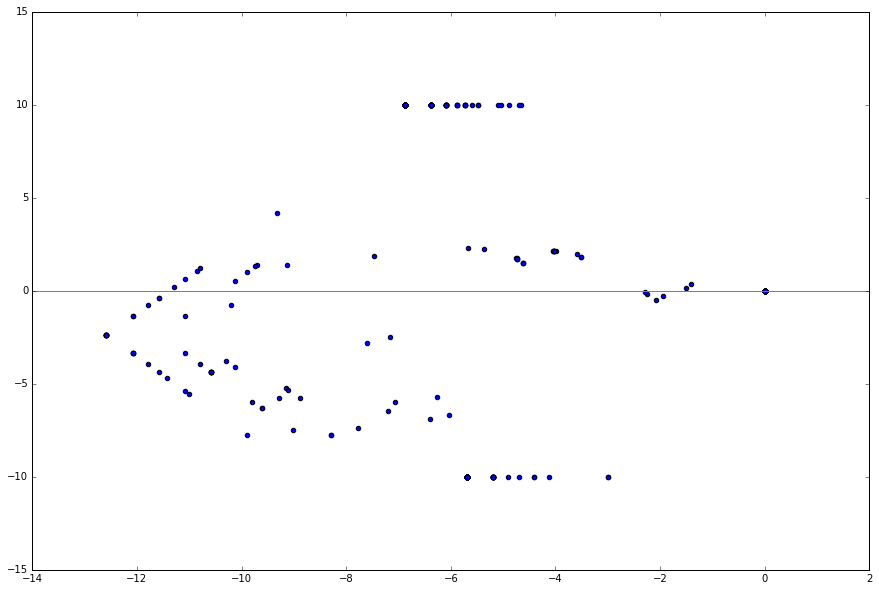

In [32]:
# "normal" ma plot
fig = plt.figure(figsize=(15, 10))  # prepare figure
ax = plt.gca()                     # get axes
ax.scatter(x, y)
ax.axhline(0, color="gray");

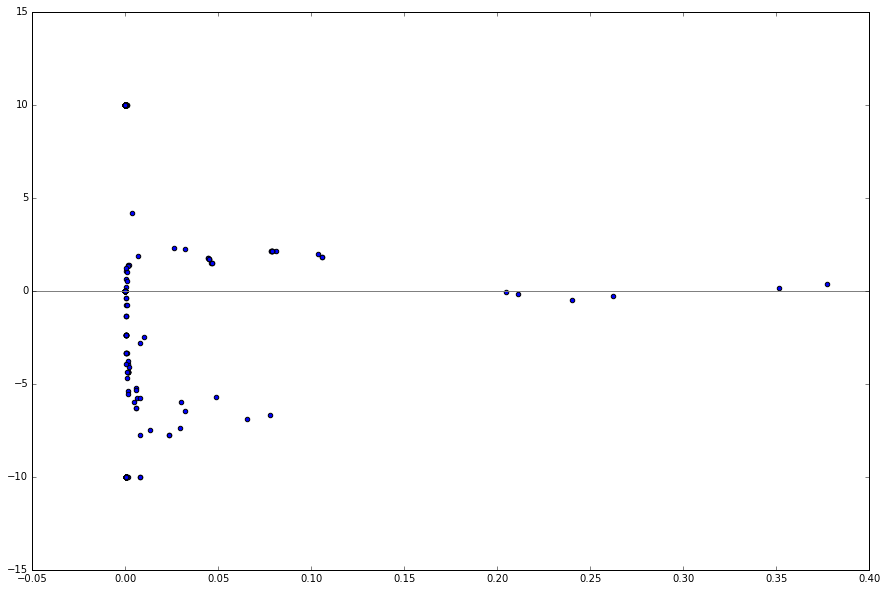

In [33]:
# my ma plot
fig = plt.figure(figsize=(15, 10))  # prepare figure
ax = plt.gca()                     # get axes
ax.scatter(my_x, y)
ax.axhline(0, color="gray");